# E-Commerce Customer Analytics - 고급 모델링 프로젝트

## 프로젝트 개요
- **데이터셋**: E-Commerce Shipping Data (Kaggle)
- **목표**: 배송 지연 예측 및 고객 분석
- **접근법**: 
  1. 상세한 탐색적 데이터 분석 (EDA)
  2. 다양한 시각화
  3. 다중 모델링 기법 적용 (Optuna, AutoGluon, 전통적 ML)
  4. 하이퍼파라미터 튜닝
  5. 모델 성능 비교 및 앙상블

## 1. 환경 설정 및 라이브러리 불러오기

In [76]:
# 필요한 라이브러리 설치 (처음 한 번만 실행)
# !pip install optuna autogluon xgboost lightgbm catboost shap plotly kaleido

import warnings
warnings.filterwarnings('ignore')

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 데이터 전처리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 평가 지표
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# 하이퍼파라미터 튜닝
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# AutoGluon
try:
    from autogluon.tabular import TabularPredictor
    AUTOGLUON_AVAILABLE = True
except ImportError:
    print("AutoGluon not installed. Install with: pip install autogluon")
    AUTOGLUON_AVAILABLE = False

# 모델 해석
# 모델 해석 (선택 사항)
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP 사용 가능")
except ImportError as e:
    print("⚠️ SHAP 라이브러리 오류로 인해 SHAP 분석은 건너뜁니다.")
    print(f"   오류 내용: {str(e)[:100]}")
    print("   해결: pip install --upgrade scikit-learn==1.3.2 shap==0.44.0")
    SHAP_AVAILABLE = False


# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# 옵션 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 시드 설정
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ 라이브러리 로드 완료!")

✅ SHAP 사용 가능
✅ 라이브러리 로드 완료!


## 2. 데이터 로드 및 기본 정보 확인

In [77]:
# 로컬 경로에서 데이터 로드
import pandas as pd
import os

print("=" * 80)
print("📥 E-Commerce Shipping 데이터 로드")
print("=" * 80)

# 데이터 경로 설정 (절대 경로)
data_path = r'C:\Users\User\github\Ecom_Shipping\data\Train.csv'

# 또는 상대 경로 (woochul 폴더에서 실행 시)
# data_path = '../data/Train.csv'

print(f"\n📂 데이터 경로: {data_path}")

try:
    # 파일 존재 확인
    if os.path.exists(data_path):
        print("✅ 파일 발견!")
        
        # 데이터 로드
        df = pd.read_csv(data_path)
        
        # 성공 메시지
        print("\n" + "=" * 80)
        print("✅ 데이터 로드 성공!")
        print("=" * 80)
        
        # 데이터셋 정보 출력
        print(f"\n📊 데이터셋 정보:")
        print(f"  • 샘플 개수: {df.shape[0]:,} 개")
        print(f"  • 특성 개수: {df.shape[1]} 개")
        print(f"  • 메모리 사용: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # 컬럼 목록
        print(f"\n📋 컬럼 목록:")
        for i, col in enumerate(df.columns, 1):
            dtype = df[col].dtype
            null_count = df[col].isnull().sum()
            print(f"  {i:2d}. {col:30s} - {str(dtype):10s} (결측: {null_count})")
        
        print("\n" + "=" * 80)
        print("데이터 미리보기 (처음 10행):")
        print("=" * 80)
        
    else:
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {data_path}")
        
except FileNotFoundError as e:
    print(f"\n❌ 오류: {e}")
    print("\n🔍 문제 해결 방법:")
    print("\n1. 경로 확인:")
    print(f"   현재 작업 디렉토리: {os.getcwd()}")
    print(f"   찾으려는 파일: {data_path}")
    
    print("\n2. 파일 존재 확인:")
    data_dir = r'C:\Users\User\github\Ecom_Shipping\data'
    if os.path.exists(data_dir):
        print(f"   data 폴더 존재: ✅")
        print(f"   폴더 내용: {os.listdir(data_dir)}")
    else:
        print(f"   data 폴더 존재: ❌")
    
    print("\n3. 해결책:")
    print("   • PowerShell에서 확인: ls C:\\Users\\User\\github\\Ecom_Shipping\\data")
    print("   • 파일명 대소문자 확인: Train.csv vs train.csv")
    
    raise

except Exception as e:
    print(f"\n❌ 예상치 못한 오류: {e}")
    raise

# 데이터 미리보기
df.head(10)

📥 E-Commerce Shipping 데이터 로드

📂 데이터 경로: C:\Users\User\github\Ecom_Shipping\data\Train.csv
✅ 파일 발견!

✅ 데이터 로드 성공!

📊 데이터셋 정보:
  • 샘플 개수: 10,999 개
  • 특성 개수: 12 개
  • 메모리 사용: 3.18 MB

📋 컬럼 목록:
   1. ID                             - int64      (결측: 0)
   2. Warehouse_block                - object     (결측: 0)
   3. Mode_of_Shipment               - object     (결측: 0)
   4. Customer_care_calls            - int64      (결측: 0)
   5. Customer_rating                - int64      (결측: 0)
   6. Cost_of_the_Product            - int64      (결측: 0)
   7. Prior_purchases                - int64      (결측: 0)
   8. Product_importance             - object     (결측: 0)
   9. Gender                         - object     (결측: 0)
  10. Discount_offered               - int64      (결측: 0)
  11. Weight_in_gms                  - int64      (결측: 0)
  12. Reached.on.Time_Y.N            - int64      (결측: 0)

데이터 미리보기 (처음 10행):


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
5,6,F,Flight,3,1,162,3,medium,F,12,1417,1
6,7,D,Flight,3,4,250,3,low,F,3,2371,1
7,8,F,Flight,4,1,233,2,low,F,48,2804,1
8,9,A,Flight,3,4,150,3,low,F,11,1861,1
9,10,B,Flight,3,2,164,3,medium,F,29,1187,1


In [78]:
# 데이터 타입 및 결측치 확인
print("📊 데이터 타입 및 결측치 정보:\n")
print(df.info())
print("\n" + "="*80)
print("\n결측치 개수:")
print(df.isnull().sum())
print("\n결측치 비율 (%):")
print(round(df.isnull().sum() / len(df) * 100, 2))

📊 데이터 타입 및 결측치 정보:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


결측치 개수:
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating     

In [79]:
# 기초 통계량
print("📈 수치형 변수 기초 통계량:\n")
df.describe()

📈 수치형 변수 기초 통계량:



,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [80]:
# 범주형 변수 확인
print("📋 범주형 변수 고유값 개수:\n")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} 개")
    print(f"  - {df[col].value_counts().head(5).to_dict()}")
    print()

📋 범주형 변수 고유값 개수:

Warehouse_block: 5 개
  - {'F': 3666, 'D': 1834, 'A': 1833, 'B': 1833, 'C': 1833}

Mode_of_Shipment: 3 개
  - {'Ship': 7462, 'Flight': 1777, 'Road': 1760}

Product_importance: 3 개
  - {'low': 5297, 'medium': 4754, 'high': 948}

Gender: 2 개
  - {'F': 5545, 'M': 5454}



## 3. 탐색적 데이터 분석 (EDA) - 상세 시각화

### 3.1 타겟 변수 분석

타겟 변수: Reached.on.Time_Y.N

타겟 분포:
Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

타겟 비율:
Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


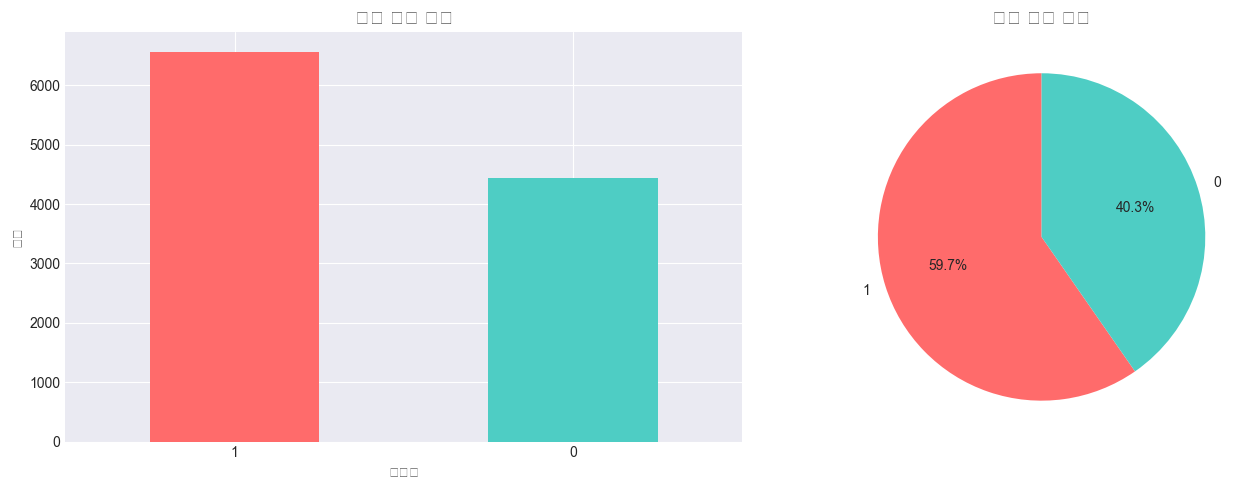


⚠️ 클래스 불균형 비율: 1.48:1


In [81]:
# 타겟 변수 확인 (일반적으로 'Reached.on.Time_Y.N' 또는 유사한 컬럼)
# 실제 데이터셋의 타겟 컬럼명으로 변경 필요
target_col = 'Reached.on.Time_Y.N' if 'Reached.on.Time_Y.N' in df.columns else df.columns[-1]

print(f"타겟 변수: {target_col}")
print(f"\n타겟 분포:")
print(df[target_col].value_counts())
print(f"\n타겟 비율:")
print(df[target_col].value_counts(normalize=True))

# 타겟 변수 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 카운트 플롯
df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('타겟 변수 분포', fontsize=14, weight='bold')
axes[0].set_xlabel('클래스')
axes[0].set_ylabel('개수')
axes[0].tick_params(rotation=0)

# 파이 차트
df[target_col].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                     colors=['#FF6B6B', '#4ECDC4'], startangle=90)
axes[1].set_title('타겟 변수 비율', fontsize=14, weight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# 불균형 정도 계산
target_counts = df[target_col].value_counts()
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\n⚠️ 클래스 불균형 비율: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("→ 불균형 데이터입니다. SMOTE, 가중치 조정 등을 고려하세요.")

### 3.2 수치형 변수 분석

수치형 변수 개수: 7
변수 목록: ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']



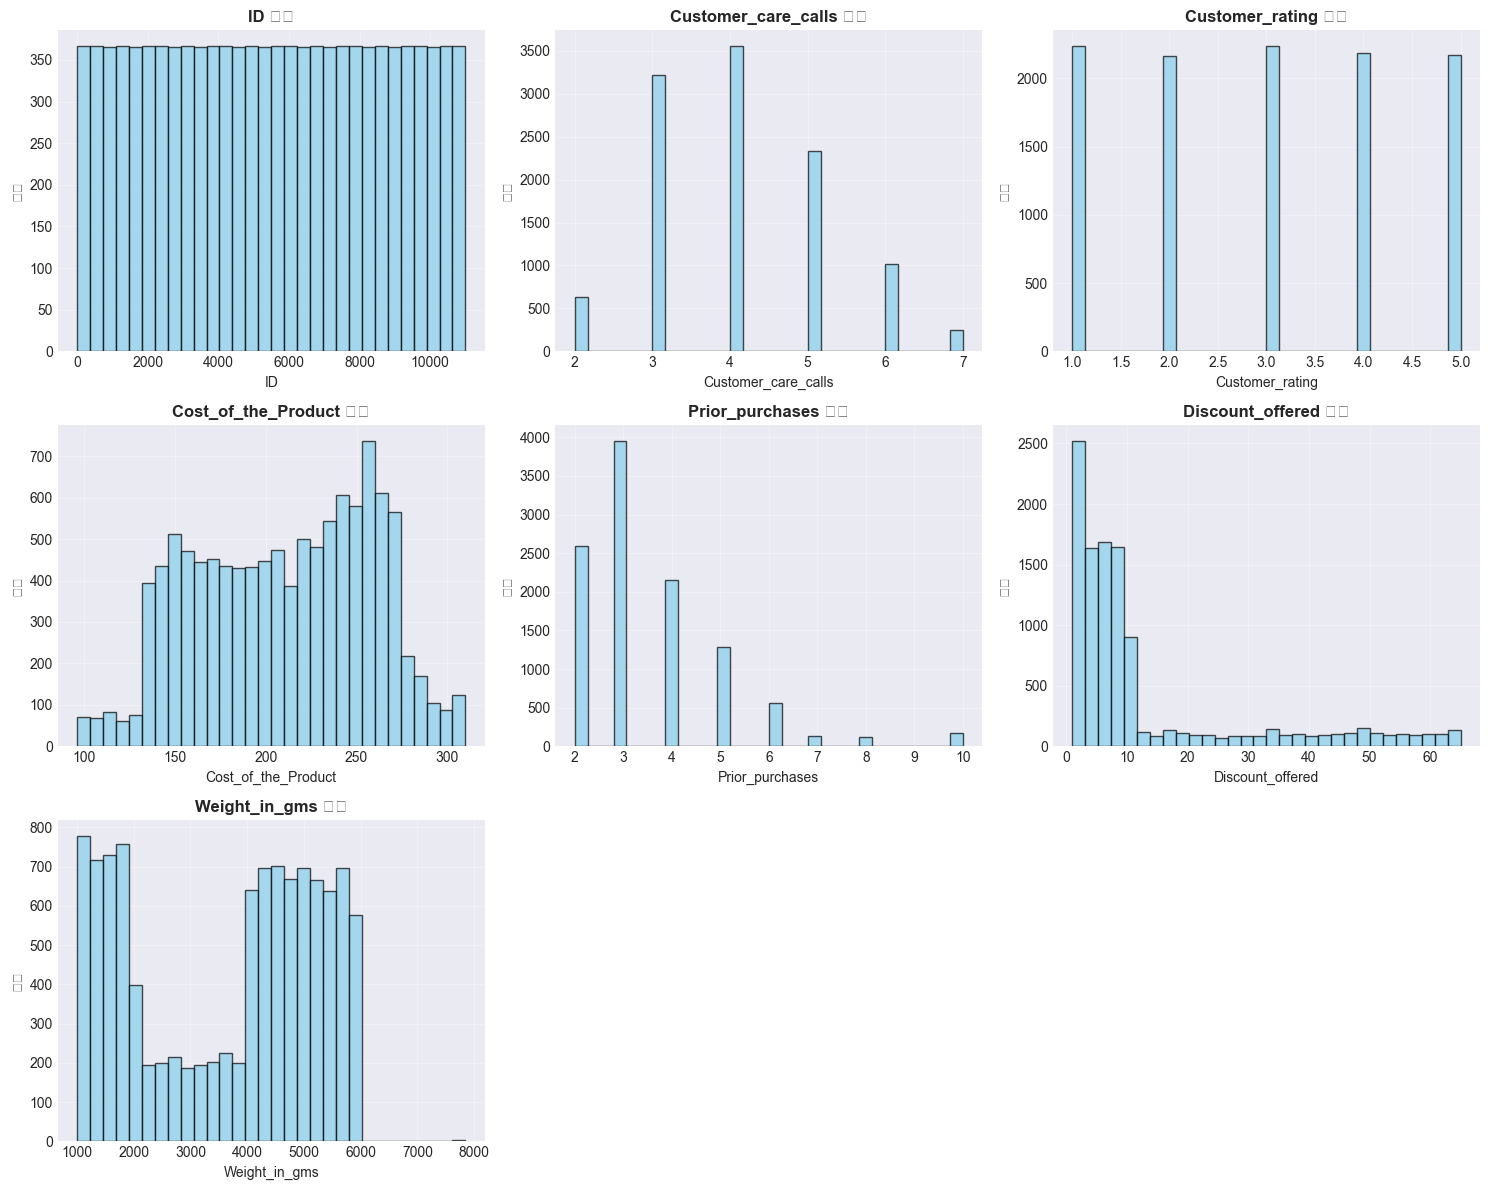

In [82]:
# 수치형 변수 분포 시각화
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print(f"수치형 변수 개수: {len(numeric_cols)}")
print(f"변수 목록: {numeric_cols}\n")

# 분포 히스토그램
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} 분포', fontsize=12, weight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('빈도')
    axes[idx].grid(True, alpha=0.3)

# 빈 subplot 제거
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

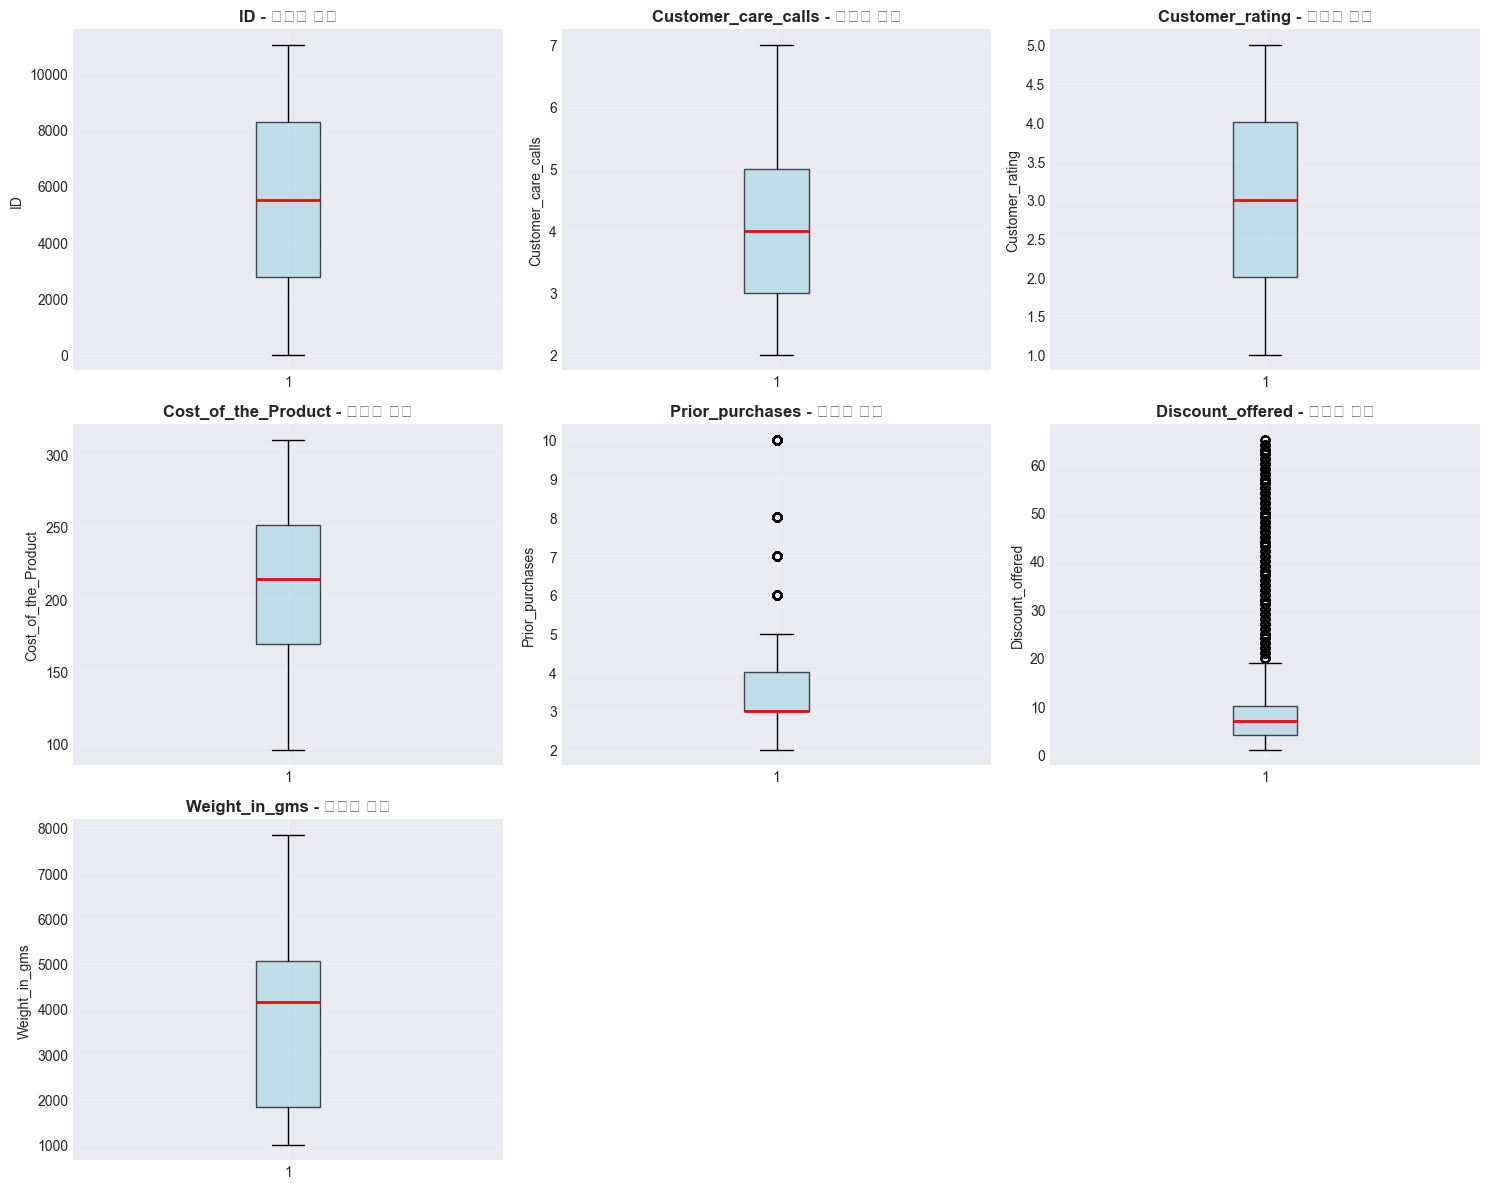

In [83]:
# Box Plot - 이상치 탐지
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col} - 이상치 확인', fontsize=12, weight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

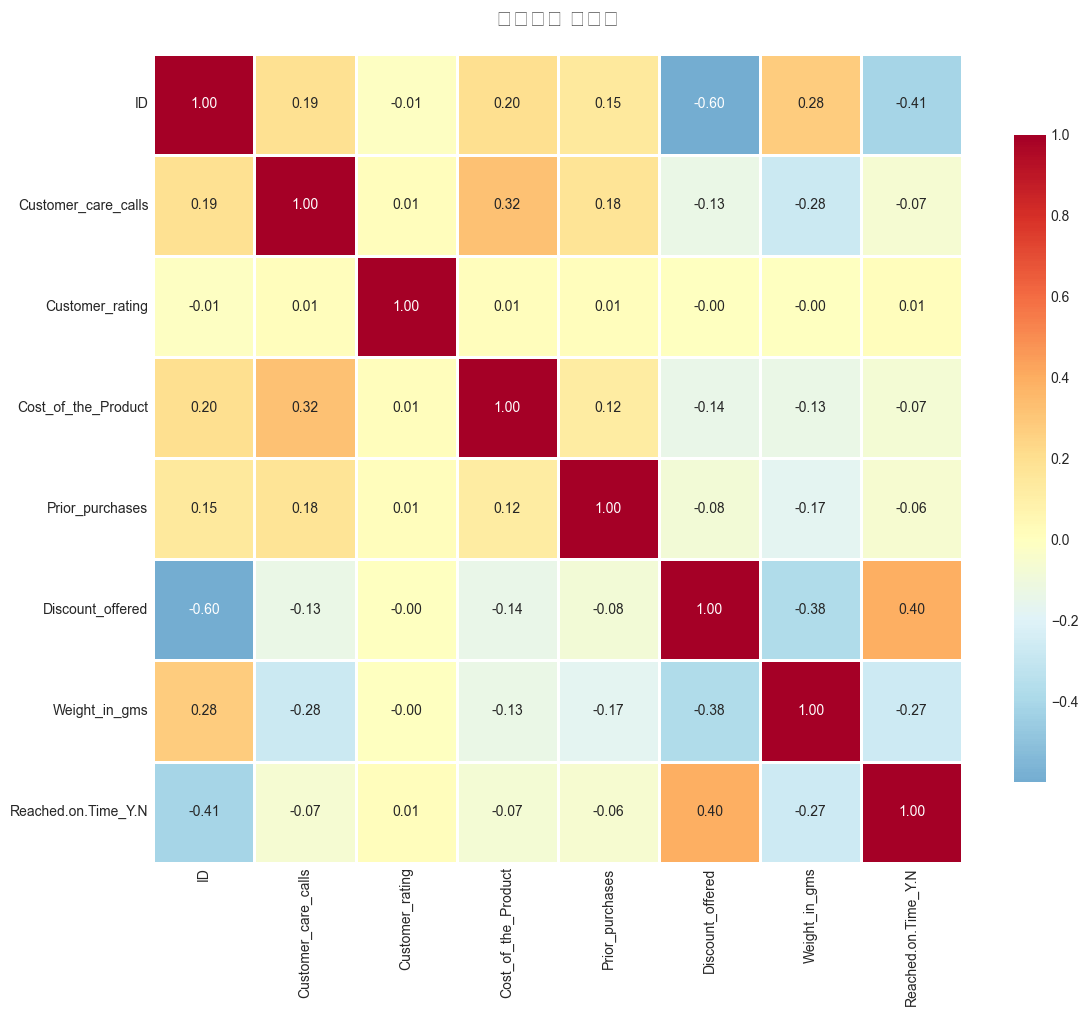


📊 타겟과의 상관관계 Top 10:
Discount_offered       0.397108
Customer_rating        0.013119
Prior_purchases       -0.055515
Customer_care_calls   -0.067126
Cost_of_the_Product   -0.073587
Weight_in_gms         -0.268793
ID                    -0.411822
Name: Reached.on.Time_Y.N, dtype: float64


In [84]:
# 상관관계 분석
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols + [target_col]].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('상관관계 히트맵', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

# 타겟과의 상관관계 Top 10
print("\n📊 타겟과의 상관관계 Top 10:")
target_corr = correlation_matrix[target_col].sort_values(ascending=False)
print(target_corr[1:11])  # 자기 자신 제외

### 3.3 범주형 변수 분석

범주형 변수 개수: 4
변수 목록: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']



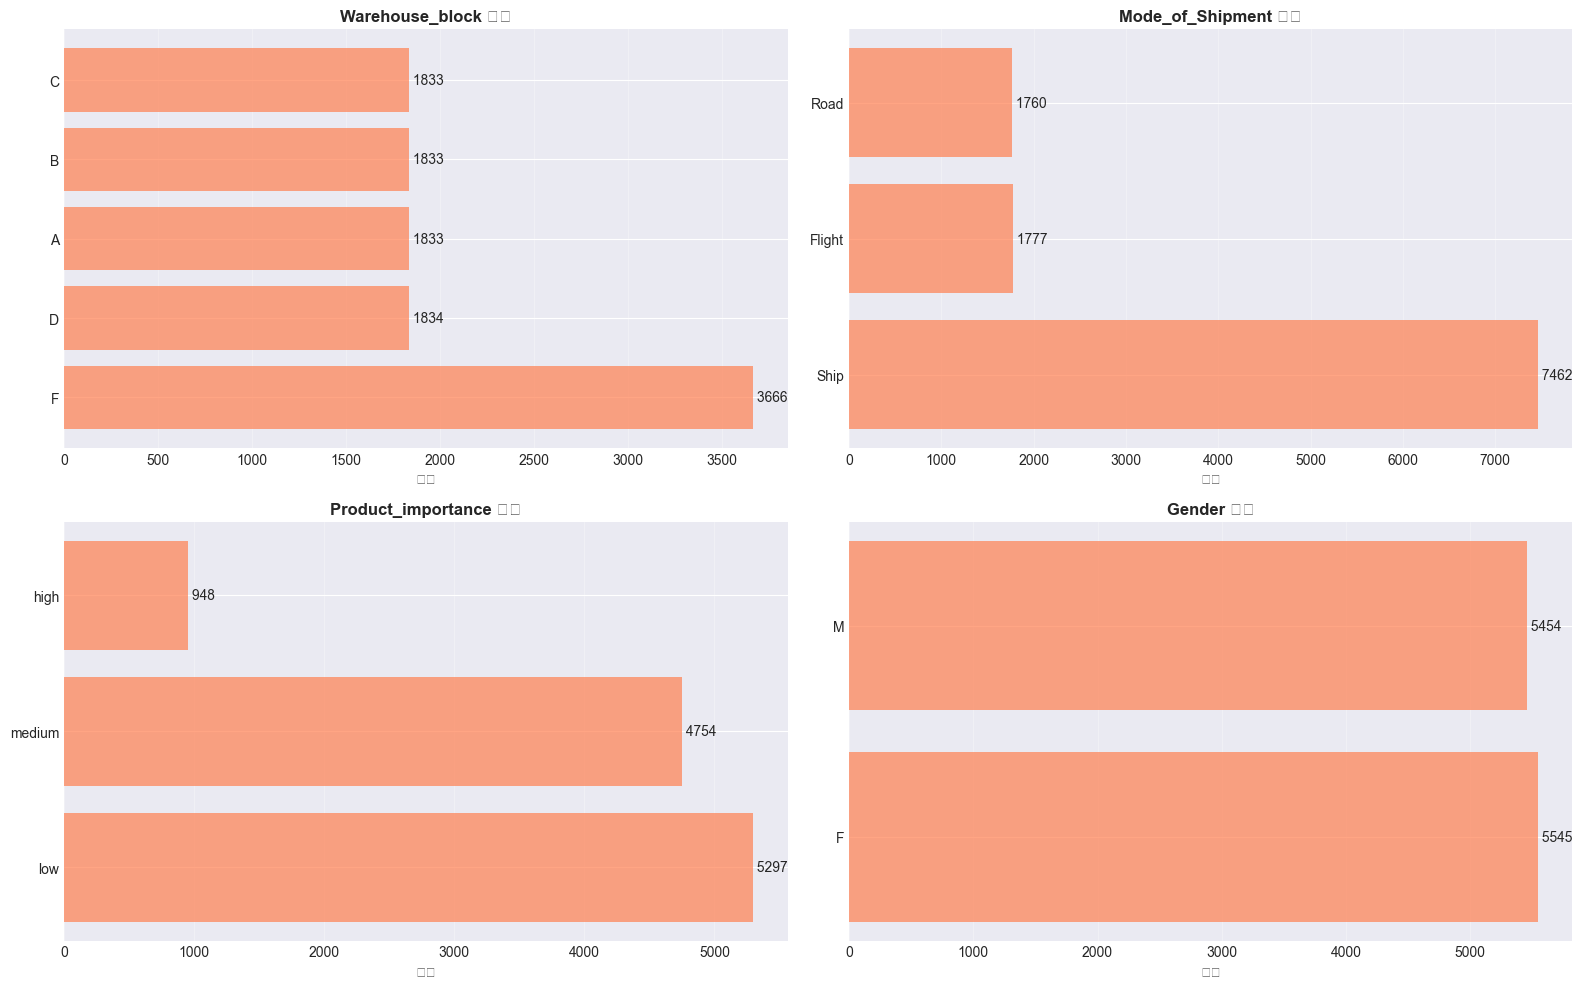

In [85]:
# 범주형 변수 분포
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"범주형 변수 개수: {len(categorical_cols)}")
print(f"변수 목록: {categorical_cols}\n")

n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].barh(range(len(value_counts)), value_counts.values, color='coral', alpha=0.7)
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index)
    axes[idx].set_xlabel('개수')
    axes[idx].set_title(f'{col} 분포', fontsize=12, weight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # 값 레이블 추가
    for i, v in enumerate(value_counts.values):
        axes[idx].text(v, i, f' {v}', va='center')

for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

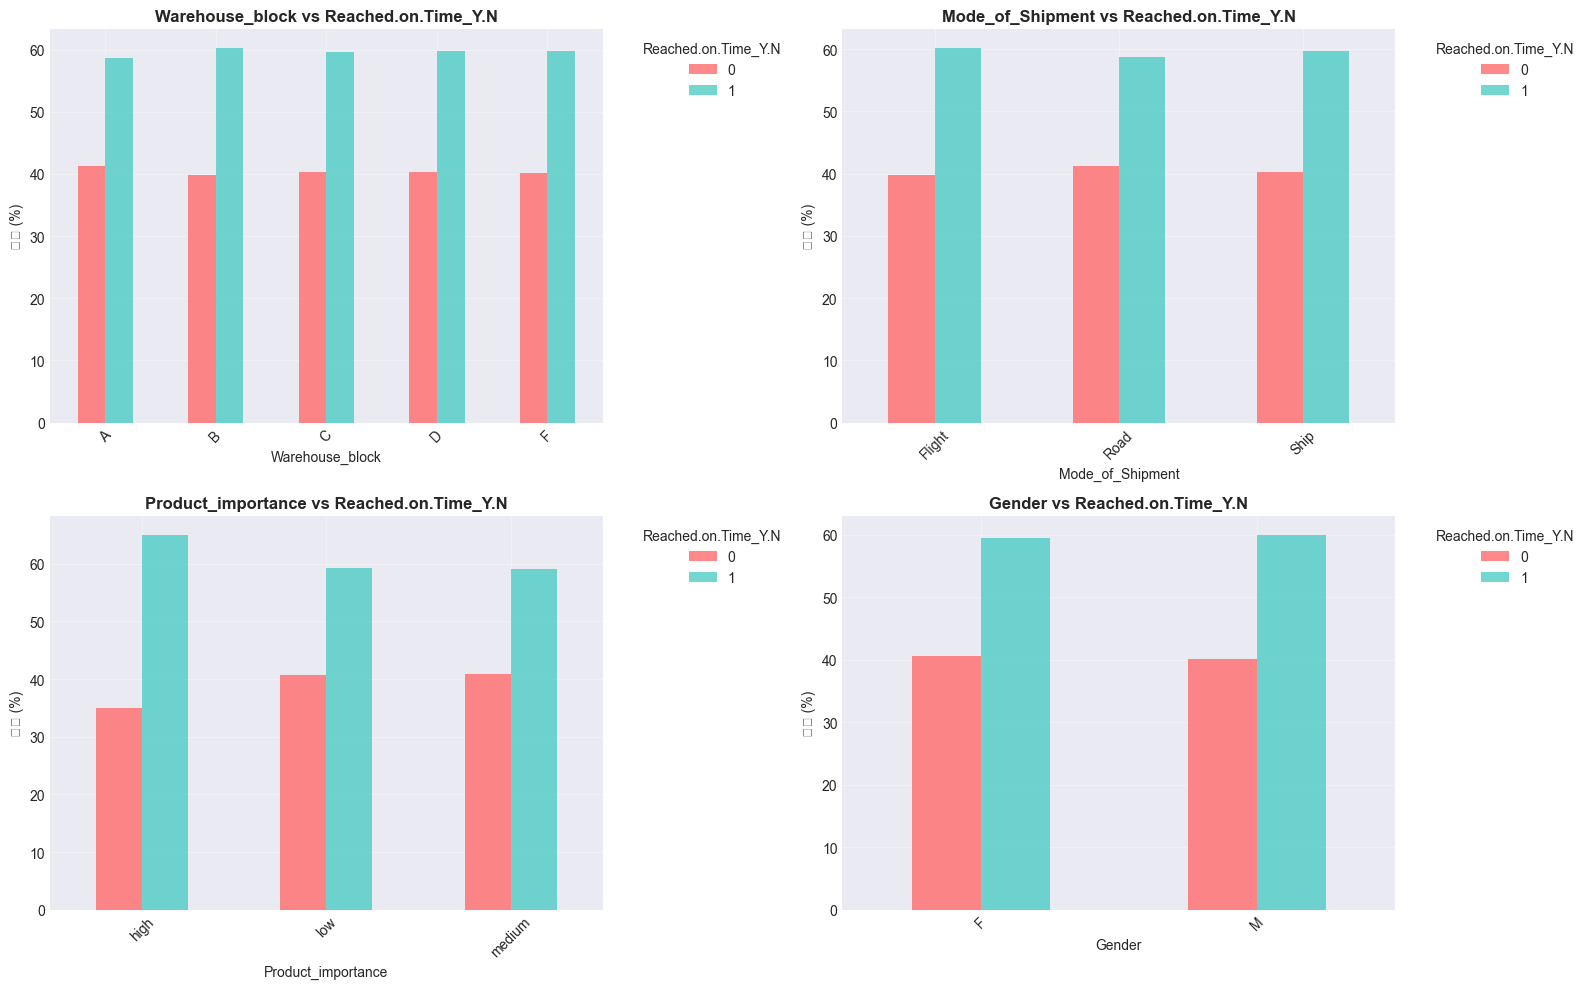

In [86]:
# 범주형 변수와 타겟의 관계
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(categorical_cols):
    crosstab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    crosstab.plot(kind='bar', ax=axes[idx], stacked=False, 
                  color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[idx].set_title(f'{col} vs {target_col}', fontsize=12, weight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('비율 (%)')
    axes[idx].legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

### 3.4 고급 시각화 (Plotly Interactive)

In [87]:
# Plotly 인터랙티브 시각화
if len(numeric_cols) >= 2:
    fig = px.scatter(
        df, 
        x=numeric_cols[0], 
        y=numeric_cols[1], 
        color=target_col,
        title=f'{numeric_cols[0]} vs {numeric_cols[1]} (타겟별)',
        hover_data=df.columns,
        opacity=0.6,
        color_discrete_sequence=['#FF6B6B', '#4ECDC4']
    )
    fig.update_layout(height=600, template='plotly_white')
    fig.show()

In [88]:
# Parallel Coordinates Plot
if len(numeric_cols) >= 3:
    sample_df = df.sample(min(1000, len(df)))  # 샘플링으로 성능 개선
    
    fig = px.parallel_coordinates(
        sample_df,
        dimensions=numeric_cols[:5] + [target_col],  # 최대 5개 변수
        color=target_col,
        title='변수 간 관계 (Parallel Coordinates)',
        color_continuous_scale=px.colors.diverging.Tealrose
    )
    fig.update_layout(height=600, template='plotly_white')
    fig.show()

## 4. 데이터 전처리

In [89]:
# 데이터 복사
df_processed = df.copy()

print("🔧 데이터 전처리 시작...\n")

# 1. 결측치 처리
print("1. 결측치 처리")
if df_processed.isnull().sum().sum() > 0:
    # 수치형: 중앙값
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
            print(f"  - {col}: 중앙값으로 대체")
    
    # 범주형: 최빈값
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
            print(f"  - {col}: 최빈값으로 대체")
else:
    print("  - 결측치 없음")

print("\n2. 범주형 변수 인코딩")
# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} 클래스")

print("\n✅ 전처리 완료!")
print(f"최종 데이터셋 크기: {df_processed.shape}")

🔧 데이터 전처리 시작...

1. 결측치 처리
  - 결측치 없음

2. 범주형 변수 인코딩
  - Warehouse_block: 5 클래스
  - Mode_of_Shipment: 3 클래스
  - Product_importance: 3 클래스
  - Gender: 2 클래스

✅ 전처리 완료!
최종 데이터셋 크기: (10999, 12)


In [90]:
# 특성과 타겟 분리
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"특성 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")
print(f"\n특성 목록:")
print(X.columns.tolist())

특성 개수: 11
샘플 개수: 10999

특성 목록:
['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms']


In [91]:
# Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("📊 데이터 분할 완료")
print(f"Train: {X_train.shape[0]} 샘플 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} 샘플 ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTrain 타겟 분포:")
print(y_train.value_counts())
print(f"\nTest 타겟 분포:")
print(y_test.value_counts())

📊 데이터 분할 완료
Train: 8799 샘플 (80.0%)
Test: 2200 샘플 (20.0%)

Train 타겟 분포:
Reached.on.Time_Y.N
1    5250
0    3549
Name: count, dtype: int64

Test 타겟 분포:
Reached.on.Time_Y.N
1    1313
0     887
Name: count, dtype: int64


In [92]:
# 스케일링 (선택적 - 일부 모델에만 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ 스케일링 완료")

✅ 스케일링 완료


## 5. 베이스라인 모델 - 여러 알고리즘 비교

In [93]:
# 베이스라인 모델 정의
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_estimators=100, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, iterations=100, verbose=0)
}

print("🎯 베이스라인 모델 학습 시작...\n")

🎯 베이스라인 모델 학습 시작...



In [94]:
# 모델 학습 및 평가
baseline_results = []

for name, model in baseline_models.items():
    print(f"\n{'='*60}")
    print(f"📈 {name} 학습 중...")
    print('='*60)
    
    # 학습 (스케일링이 필요한 모델은 scaled 데이터 사용)
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = 0
    
    baseline_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n결과:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

print("\n" + "="*60)
print("✅ 모든 베이스라인 모델 학습 완료!")
print("="*60)


📈 Logistic Regression 학습 중...

결과:
  Accuracy:  0.6536
  Precision: 0.6623
  Recall:    0.6536
  F1-Score:  0.6562
  ROC-AUC:   0.7334

📈 Decision Tree 학습 중...

결과:
  Accuracy:  0.6641
  Precision: 0.6644
  Recall:    0.6641
  F1-Score:  0.6642
  ROC-AUC:   0.6515

📈 Random Forest 학습 중...

결과:
  Accuracy:  0.6700
  Precision: 0.7003
  Recall:    0.6700
  F1-Score:  0.6726
  ROC-AUC:   0.7435

📈 Gradient Boosting 학습 중...

결과:
  Accuracy:  0.6786
  Precision: 0.7791
  Recall:    0.6786
  F1-Score:  0.6715
  ROC-AUC:   0.7468

📈 XGBoost 학습 중...

결과:
  Accuracy:  0.6523
  Precision: 0.6650
  Recall:    0.6523
  F1-Score:  0.6554
  ROC-AUC:   0.7303

📈 LightGBM 학습 중...

결과:
  Accuracy:  0.6677
  Precision: 0.7014
  Recall:    0.6677
  F1-Score:  0.6700
  ROC-AUC:   0.7407

📈 CatBoost 학습 중...

결과:
  Accuracy:  0.6673
  Precision: 0.7201
  Recall:    0.6673
  F1-Score:  0.6672
  ROC-AUC:   0.7395

✅ 모든 베이스라인 모델 학습 완료!



📊 베이스라인 모델 성능 비교:

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.670000   0.700261 0.670000  0.672586 0.743542
  Gradient Boosting  0.678636   0.779052 0.678636  0.671504 0.746843
           LightGBM  0.667727   0.701419 0.667727  0.670016 0.740650
           CatBoost  0.667273   0.720074 0.667273  0.667154 0.739456
      Decision Tree  0.664091   0.664401 0.664091  0.664243 0.651463
Logistic Regression  0.653636   0.662307 0.653636  0.656234 0.733407
            XGBoost  0.652273   0.665018 0.652273  0.655353 0.730343


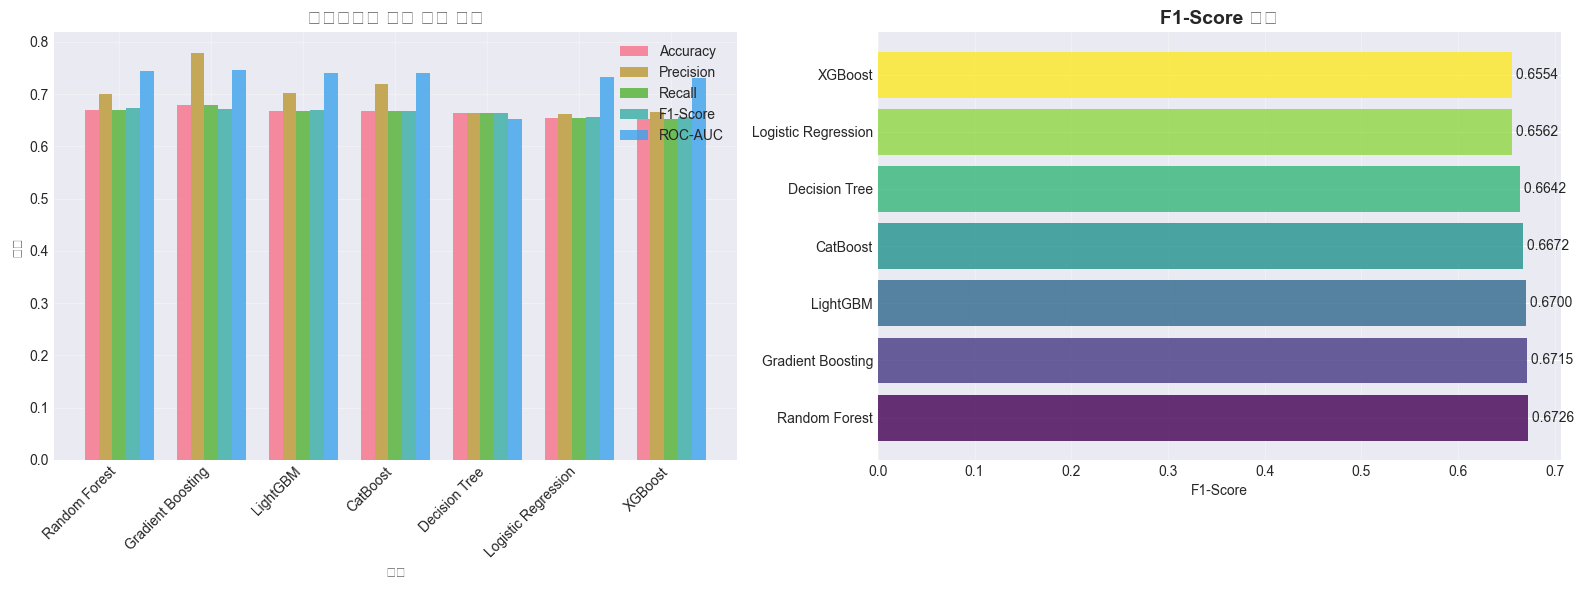

In [95]:
# 결과 비교
results_df = pd.DataFrame(baseline_results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n📊 베이스라인 모델 성능 비교:\n")
print(results_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 막대 그래프
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('모델')
axes[0].set_ylabel('점수')
axes[0].set_title('베이스라인 모델 성능 비교', fontsize=14, weight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1-Score 막대 그래프
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
axes[1].barh(results_df['Model'], results_df['F1-Score'], color=colors, alpha=0.8)
axes[1].set_xlabel('F1-Score')
axes[1].set_title('F1-Score 순위', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# 값 레이블
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v, i, f' {v:.4f}', va='center')

plt.tight_layout()
plt.show()

## 6. Optuna를 활용한 하이퍼파라미터 튜닝

In [96]:
# 최고 성능 모델 선택 (여기서는 상위 3개 모델 튜닝)
top_models = results_df.head(3)['Model'].tolist()
print(f"🎯 튜닝 대상 모델: {top_models}")

🎯 튜닝 대상 모델: ['Random Forest', 'Gradient Boosting', 'LightGBM']


### 6.1 XGBoost Optuna 튜닝

In [97]:
print("\n" + "="*60)
print("🔧 XGBoost Optuna 튜닝 시작")
print("="*60)

def objective_xgb(trial):
    """XGBoost 목적 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    
    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=1
    )
    
    return cv_scores.mean()

# Optuna Study
study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost_Tuning')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print("\n✅ XGBoost 튜닝 완료!")
print(f"최적 F1-Score: {study_xgb.best_value:.4f}")
print(f"\n최적 하이퍼파라미터:")
for key, value in study_xgb.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-12 13:20:56,984] A new study created in memory with name: XGBoost_Tuning



🔧 XGBoost Optuna 튜닝 시작


Best trial: 0. Best value: 0.646623:   2%|▏         | 1/50 [00:03<02:47,  3.41s/it]

[I 2026-02-12 13:21:00,398] Trial 0 finished with value: 0.6466229157708211 and parameters: {'n_estimators': 349, 'max_depth': 9, 'learning_rate': 0.184200188251723, 'subsample': 0.8670158159648835, 'colsample_bytree': 0.9829662477814043, 'min_child_weight': 10, 'gamma': 0.16142273594102768, 'reg_alpha': 0.846582287945737, 'reg_lambda': 0.9836890616937695}. Best is trial 0 with value: 0.6466229157708211.


Best trial: 1. Best value: 0.656155:   4%|▍         | 2/50 [00:04<01:46,  2.23s/it]

[I 2026-02-12 13:21:01,798] Trial 1 finished with value: 0.6561553531632202 and parameters: {'n_estimators': 397, 'max_depth': 3, 'learning_rate': 0.17267455481388783, 'subsample': 0.8462590948208237, 'colsample_bytree': 0.7470201065797508, 'min_child_weight': 8, 'gamma': 0.2834945604242722, 'reg_alpha': 0.8247565522294559, 'reg_lambda': 0.9036026936668136}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:   6%|▌         | 3/50 [00:08<02:17,  2.92s/it]

[I 2026-02-12 13:21:05,536] Trial 2 finished with value: 0.6472683479934519 and parameters: {'n_estimators': 420, 'max_depth': 8, 'learning_rate': 0.28016745362507656, 'subsample': 0.8447662387364525, 'colsample_bytree': 0.6657370885530948, 'min_child_weight': 10, 'gamma': 0.07674913796204724, 'reg_alpha': 0.21290352080422625, 'reg_lambda': 0.6656013377669248}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:   8%|▊         | 4/50 [00:17<04:03,  5.30s/it]

[I 2026-02-12 13:21:14,478] Trial 3 finished with value: 0.6549965593026446 and parameters: {'n_estimators': 875, 'max_depth': 10, 'learning_rate': 0.021628799509308648, 'subsample': 0.7554136736746039, 'colsample_bytree': 0.8681101038109323, 'min_child_weight': 10, 'gamma': 0.13379851185718472, 'reg_alpha': 0.23454483849571117, 'reg_lambda': 0.35662854247060827}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:  10%|█         | 5/50 [00:20<03:24,  4.55s/it]

[I 2026-02-12 13:21:17,714] Trial 4 finished with value: 0.6534158281909368 and parameters: {'n_estimators': 893, 'max_depth': 9, 'learning_rate': 0.25032244337996623, 'subsample': 0.8504779700039682, 'colsample_bytree': 0.9585722314120744, 'min_child_weight': 1, 'gamma': 0.4990932834678372, 'reg_alpha': 0.6052894820642699, 'reg_lambda': 0.9364403992747047}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:  12%|█▏        | 6/50 [00:21<02:29,  3.40s/it]

[I 2026-02-12 13:21:18,870] Trial 5 finished with value: 0.6552097688008665 and parameters: {'n_estimators': 137, 'max_depth': 7, 'learning_rate': 0.16163513653111664, 'subsample': 0.610768350424972, 'colsample_bytree': 0.8098165190518881, 'min_child_weight': 8, 'gamma': 0.005634551055381021, 'reg_alpha': 0.5655819870172635, 'reg_lambda': 0.763932865272992}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:  14%|█▍        | 7/50 [00:25<02:32,  3.54s/it]

[I 2026-02-12 13:21:22,705] Trial 6 finished with value: 0.6526882937896984 and parameters: {'n_estimators': 477, 'max_depth': 9, 'learning_rate': 0.18495591588345162, 'subsample': 0.6801367343273785, 'colsample_bytree': 0.7780440533268922, 'min_child_weight': 2, 'gamma': 0.31868027953942885, 'reg_alpha': 0.2909427714252302, 'reg_lambda': 0.8729167456360503}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:  16%|█▌        | 8/50 [00:30<02:48,  4.01s/it]

[I 2026-02-12 13:21:27,724] Trial 7 finished with value: 0.6453440861663153 and parameters: {'n_estimators': 814, 'max_depth': 5, 'learning_rate': 0.24921689474768555, 'subsample': 0.6791220607487652, 'colsample_bytree': 0.7053038444931508, 'min_child_weight': 7, 'gamma': 0.42517988514634136, 'reg_alpha': 0.49465698430457283, 'reg_lambda': 0.04405151572773103}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 1. Best value: 0.656155:  18%|█▊        | 9/50 [00:34<02:38,  3.86s/it]

[I 2026-02-12 13:21:31,247] Trial 8 finished with value: 0.6525062124251344 and parameters: {'n_estimators': 472, 'max_depth': 6, 'learning_rate': 0.05833177504992921, 'subsample': 0.7151985456339802, 'colsample_bytree': 0.6235130811774849, 'min_child_weight': 5, 'gamma': 0.0844937744363991, 'reg_alpha': 0.6655845248683283, 'reg_lambda': 0.7146292834131472}. Best is trial 1 with value: 0.6561553531632202.


Best trial: 9. Best value: 0.659112:  20%|██        | 10/50 [00:35<02:01,  3.03s/it]

[I 2026-02-12 13:21:32,428] Trial 9 finished with value: 0.6591116442405676 and parameters: {'n_estimators': 144, 'max_depth': 6, 'learning_rate': 0.10995618773926295, 'subsample': 0.8552301165549601, 'colsample_bytree': 0.6522668960057603, 'min_child_weight': 5, 'gamma': 0.2825526317223679, 'reg_alpha': 0.24462508658459403, 'reg_lambda': 0.81662485824355}. Best is trial 9 with value: 0.6591116442405676.


Best trial: 10. Best value: 0.667769:  22%|██▏       | 11/50 [00:36<01:29,  2.30s/it]

[I 2026-02-12 13:21:33,075] Trial 10 finished with value: 0.6677690707054027 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.09985136028796243, 'subsample': 0.9788764282357478, 'colsample_bytree': 0.6050461804101204, 'min_child_weight': 4, 'gamma': 0.3576505975687322, 'reg_alpha': 0.0576671759383075, 'reg_lambda': 0.47453675870738293}. Best is trial 10 with value: 0.6677690707054027.


Best trial: 11. Best value: 0.672226:  24%|██▍       | 12/50 [00:36<01:07,  1.78s/it]

[I 2026-02-12 13:21:33,651] Trial 11 finished with value: 0.6722261975747681 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.08844824998310469, 'subsample': 0.9880501376338121, 'colsample_bytree': 0.6247623284851754, 'min_child_weight': 4, 'gamma': 0.34464137306432646, 'reg_alpha': 0.06250245724295325, 'reg_lambda': 0.48520119402973694}. Best is trial 11 with value: 0.6722261975747681.


Best trial: 11. Best value: 0.672226:  26%|██▌       | 13/50 [00:37<00:55,  1.50s/it]

[I 2026-02-12 13:21:34,509] Trial 12 finished with value: 0.6683530190873943 and parameters: {'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.09566365227972126, 'subsample': 0.9923015081687591, 'colsample_bytree': 0.6274030401730216, 'min_child_weight': 3, 'gamma': 0.36911582704838186, 'reg_alpha': 0.024112807626079105, 'reg_lambda': 0.41416883947518407}. Best is trial 11 with value: 0.6722261975747681.


Best trial: 11. Best value: 0.672226:  28%|██▊       | 14/50 [00:38<00:50,  1.39s/it]

[I 2026-02-12 13:21:35,650] Trial 13 finished with value: 0.6692542435715173 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.08523490096975375, 'subsample': 0.9972009288490692, 'colsample_bytree': 0.7110810836024001, 'min_child_weight': 2, 'gamma': 0.4006668799397449, 'reg_alpha': 0.01141139758104541, 'reg_lambda': 0.3527683802728659}. Best is trial 11 with value: 0.6722261975747681.


Best trial: 14. Best value: 0.673191:  30%|███       | 15/50 [00:40<00:49,  1.43s/it]

[I 2026-02-12 13:21:37,158] Trial 14 finished with value: 0.6731907529197323 and parameters: {'n_estimators': 265, 'max_depth': 4, 'learning_rate': 0.01940801707439259, 'subsample': 0.9337482062911938, 'colsample_bytree': 0.7033302577277276, 'min_child_weight': 3, 'gamma': 0.445730914960333, 'reg_alpha': 0.38983307829958236, 'reg_lambda': 0.24181046036589382}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  32%|███▏      | 16/50 [00:43<01:12,  2.12s/it]

[I 2026-02-12 13:21:40,888] Trial 15 finished with value: 0.6630744193143261 and parameters: {'n_estimators': 656, 'max_depth': 5, 'learning_rate': 0.014871121826268655, 'subsample': 0.9141182962963297, 'colsample_bytree': 0.7105271700616879, 'min_child_weight': 4, 'gamma': 0.49830564470592864, 'reg_alpha': 0.3807291455782381, 'reg_lambda': 0.19692985691001008}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  34%|███▍      | 17/50 [00:44<00:59,  1.80s/it]

[I 2026-02-12 13:21:41,933] Trial 16 finished with value: 0.6653909323440174 and parameters: {'n_estimators': 238, 'max_depth': 4, 'learning_rate': 0.05047819324687952, 'subsample': 0.9281292362018599, 'colsample_bytree': 0.8425626151803813, 'min_child_weight': 6, 'gamma': 0.22003733448651225, 'reg_alpha': 0.4564635707899172, 'reg_lambda': 0.5954469792354482}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  36%|███▌      | 18/50 [00:47<01:04,  2.02s/it]

[I 2026-02-12 13:21:44,483] Trial 17 finished with value: 0.6555499247913236 and parameters: {'n_estimators': 593, 'max_depth': 5, 'learning_rate': 0.12643253846151972, 'subsample': 0.9275029366959743, 'colsample_bytree': 0.6750639804718149, 'min_child_weight': 3, 'gamma': 0.4416133892577336, 'reg_alpha': 0.9787262364087802, 'reg_lambda': 0.21731302710336178}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  38%|███▊      | 19/50 [00:51<01:24,  2.72s/it]

[I 2026-02-12 13:21:48,840] Trial 18 finished with value: 0.6581015455756181 and parameters: {'n_estimators': 719, 'max_depth': 4, 'learning_rate': 0.05169092410179859, 'subsample': 0.9496514906790603, 'colsample_bytree': 0.7409965089046389, 'min_child_weight': 4, 'gamma': 0.22700690464308465, 'reg_alpha': 0.12276561060983707, 'reg_lambda': 0.2180164494199657}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  40%|████      | 20/50 [00:54<01:18,  2.62s/it]

[I 2026-02-12 13:21:51,215] Trial 19 finished with value: 0.6502139879470216 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.13568300087852928, 'subsample': 0.7965436247590196, 'colsample_bytree': 0.8796388544638867, 'min_child_weight': 1, 'gamma': 0.34301073395595894, 'reg_alpha': 0.38638400947227003, 'reg_lambda': 0.5645166886956905}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  42%|████▏     | 21/50 [00:56<01:08,  2.37s/it]

[I 2026-02-12 13:21:52,990] Trial 20 finished with value: 0.6621521416444679 and parameters: {'n_estimators': 322, 'max_depth': 4, 'learning_rate': 0.06801066687417825, 'subsample': 0.9005041551546453, 'colsample_bytree': 0.7629914097696384, 'min_child_weight': 6, 'gamma': 0.4605440617641994, 'reg_alpha': 0.13927603989997844, 'reg_lambda': 0.04151073429107757}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 14. Best value: 0.673191:  44%|████▍     | 22/50 [00:57<00:55,  1.98s/it]

[I 2026-02-12 13:21:54,077] Trial 21 finished with value: 0.6682575132057431 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.08111705897243719, 'subsample': 0.9974809572287519, 'colsample_bytree': 0.6985340071050385, 'min_child_weight': 2, 'gamma': 0.3999370136943251, 'reg_alpha': 0.020097003164676885, 'reg_lambda': 0.3422394091013795}. Best is trial 14 with value: 0.6731907529197323.


Best trial: 22. Best value: 0.67583:  46%|████▌     | 23/50 [00:57<00:44,  1.65s/it] 

[I 2026-02-12 13:21:54,966] Trial 22 finished with value: 0.6758302499399704 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.033914071741306936, 'subsample': 0.9566732309279744, 'colsample_bytree': 0.6426696516029629, 'min_child_weight': 3, 'gamma': 0.3980953692595377, 'reg_alpha': 0.3314101311179348, 'reg_lambda': 0.3094997568975208}. Best is trial 22 with value: 0.6758302499399704.


Best trial: 22. Best value: 0.67583:  48%|████▊     | 24/50 [00:59<00:40,  1.56s/it]

[I 2026-02-12 13:21:56,299] Trial 23 finished with value: 0.6680569635842287 and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.028858490106512598, 'subsample': 0.9488067159558475, 'colsample_bytree': 0.64259090600209, 'min_child_weight': 3, 'gamma': 0.3116630026363728, 'reg_alpha': 0.34666157834057987, 'reg_lambda': 0.1607106073968138}. Best is trial 22 with value: 0.6758302499399704.


Best trial: 22. Best value: 0.67583:  50%|█████     | 25/50 [01:00<00:32,  1.30s/it]

[I 2026-02-12 13:21:57,002] Trial 24 finished with value: 0.6741445709688041 and parameters: {'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.04541695106508149, 'subsample': 0.8902083908406303, 'colsample_bytree': 0.6038942349686162, 'min_child_weight': 4, 'gamma': 0.3862652290883732, 'reg_alpha': 0.4344230300831169, 'reg_lambda': 0.2917319423019671}. Best is trial 22 with value: 0.6758302499399704.


Best trial: 25. Best value: 0.675836:  52%|█████▏    | 26/50 [01:00<00:27,  1.16s/it]

[I 2026-02-12 13:21:57,837] Trial 25 finished with value: 0.6758360852707815 and parameters: {'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.040560624046092536, 'subsample': 0.8929181157012679, 'colsample_bytree': 0.674607917417668, 'min_child_weight': 3, 'gamma': 0.45971570861409594, 'reg_alpha': 0.45763261802497873, 'reg_lambda': 0.28625162267963744}. Best is trial 25 with value: 0.6758360852707815.


Best trial: 26. Best value: 0.676182:  54%|█████▍    | 27/50 [01:01<00:24,  1.08s/it]

[I 2026-02-12 13:21:58,718] Trial 26 finished with value: 0.6761815299300026 and parameters: {'n_estimators': 172, 'max_depth': 3, 'learning_rate': 0.04342965352307011, 'subsample': 0.8976502497895199, 'colsample_bytree': 0.6003060753319961, 'min_child_weight': 5, 'gamma': 0.39860115794349704, 'reg_alpha': 0.6599893563204767, 'reg_lambda': 0.29427765065511324}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  56%|█████▌    | 28/50 [01:06<00:45,  2.06s/it]

[I 2026-02-12 13:22:03,055] Trial 27 finished with value: 0.6594373012046182 and parameters: {'n_estimators': 995, 'max_depth': 3, 'learning_rate': 0.03550026116677475, 'subsample': 0.8058002868531519, 'colsample_bytree': 0.6607452835796528, 'min_child_weight': 5, 'gamma': 0.4725411522664772, 'reg_alpha': 0.7013438262184215, 'reg_lambda': 0.1546098956056577}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  58%|█████▊    | 29/50 [01:07<00:36,  1.72s/it]

[I 2026-02-12 13:22:04,001] Trial 28 finished with value: 0.6678060737473435 and parameters: {'n_estimators': 195, 'max_depth': 3, 'learning_rate': 0.06559248371573516, 'subsample': 0.8083574063565105, 'colsample_bytree': 0.6815027895409818, 'min_child_weight': 7, 'gamma': 0.4168676551682962, 'reg_alpha': 0.7792470247049355, 'reg_lambda': 0.1037036518468821}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  60%|██████    | 30/50 [01:10<00:43,  2.18s/it]

[I 2026-02-12 13:22:07,250] Trial 29 finished with value: 0.6496465098714724 and parameters: {'n_estimators': 348, 'max_depth': 6, 'learning_rate': 0.12093957130462382, 'subsample': 0.8860077542365941, 'colsample_bytree': 0.9965921846614079, 'min_child_weight': 2, 'gamma': 0.19674227889078177, 'reg_alpha': 0.5877352306589607, 'reg_lambda': 0.4089170754060587}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  62%|██████▏   | 31/50 [01:11<00:33,  1.77s/it]

[I 2026-02-12 13:22:08,059] Trial 30 finished with value: 0.6610029600452623 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.2146565733323229, 'subsample': 0.961660264610549, 'colsample_bytree': 0.7336292380719869, 'min_child_weight': 6, 'gamma': 0.47222147008295995, 'reg_alpha': 0.5297709771280446, 'reg_lambda': 0.29245110727792756}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  64%|██████▍   | 32/50 [01:11<00:26,  1.48s/it]

[I 2026-02-12 13:22:08,864] Trial 31 finished with value: 0.6733213033640614 and parameters: {'n_estimators': 154, 'max_depth': 4, 'learning_rate': 0.039952401176529845, 'subsample': 0.8829605854653485, 'colsample_bytree': 0.6055369370476963, 'min_child_weight': 4, 'gamma': 0.3839663145085791, 'reg_alpha': 0.4417442014259337, 'reg_lambda': 0.29610971223033467}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 26. Best value: 0.676182:  66%|██████▌   | 33/50 [01:13<00:26,  1.59s/it]

[I 2026-02-12 13:22:10,702] Trial 32 finished with value: 0.6761190405753135 and parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.011526090309581651, 'subsample': 0.8820169678985308, 'colsample_bytree': 0.6395761179601236, 'min_child_weight': 3, 'gamma': 0.29036600767756826, 'reg_alpha': 0.6586963228223351, 'reg_lambda': 0.4187166513586186}. Best is trial 26 with value: 0.6761815299300026.


Best trial: 33. Best value: 0.677401:  68%|██████▊   | 34/50 [01:15<00:27,  1.69s/it]

[I 2026-02-12 13:22:12,648] Trial 33 finished with value: 0.6774012507855118 and parameters: {'n_estimators': 371, 'max_depth': 3, 'learning_rate': 0.014078991783502217, 'subsample': 0.835488866172736, 'colsample_bytree': 0.6439204088637329, 'min_child_weight': 3, 'gamma': 0.2758991717260832, 'reg_alpha': 0.7075014919726067, 'reg_lambda': 0.4229272204113161}. Best is trial 33 with value: 0.6774012507855118.


Best trial: 34. Best value: 0.677907:  70%|███████   | 35/50 [01:17<00:26,  1.76s/it]

[I 2026-02-12 13:22:14,573] Trial 34 finished with value: 0.6779070513474745 and parameters: {'n_estimators': 405, 'max_depth': 3, 'learning_rate': 0.01085890775134372, 'subsample': 0.8302847371083852, 'colsample_bytree': 0.6772048787204348, 'min_child_weight': 9, 'gamma': 0.26773861699428586, 'reg_alpha': 0.7513194324726319, 'reg_lambda': 0.5585485070789273}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  72%|███████▏  | 36/50 [01:19<00:25,  1.80s/it]

[I 2026-02-12 13:22:16,454] Trial 35 finished with value: 0.6760770566271322 and parameters: {'n_estimators': 402, 'max_depth': 3, 'learning_rate': 0.010875882475042087, 'subsample': 0.828061941244291, 'colsample_bytree': 0.9476997483409253, 'min_child_weight': 8, 'gamma': 0.2670485236648589, 'reg_alpha': 0.8802002098382693, 'reg_lambda': 0.5874214040616197}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  74%|███████▍  | 37/50 [01:23<00:31,  2.46s/it]

[I 2026-02-12 13:22:20,452] Trial 36 finished with value: 0.669330618248824 and parameters: {'n_estimators': 482, 'max_depth': 5, 'learning_rate': 0.010195631748161425, 'subsample': 0.7694242004297565, 'colsample_bytree': 0.6301205084139407, 'min_child_weight': 9, 'gamma': 0.1468127538614093, 'reg_alpha': 0.7413517386475796, 'reg_lambda': 0.42370476656140543}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  76%|███████▌  | 38/50 [01:28<00:39,  3.28s/it]

[I 2026-02-12 13:22:25,652] Trial 37 finished with value: 0.652638464187868 and parameters: {'n_estimators': 525, 'max_depth': 8, 'learning_rate': 0.06961465779015794, 'subsample': 0.8317166286275349, 'colsample_bytree': 0.6603968064293687, 'min_child_weight': 9, 'gamma': 0.18759896177109298, 'reg_alpha': 0.6454553646794798, 'reg_lambda': 0.6490680078491661}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  78%|███████▊  | 39/50 [01:30<00:31,  2.89s/it]

[I 2026-02-12 13:22:27,622] Trial 38 finished with value: 0.6562707222407229 and parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.29907704980828975, 'subsample': 0.8705692599564202, 'colsample_bytree': 0.7898185896011481, 'min_child_weight': 7, 'gamma': 0.2505363196644416, 'reg_alpha': 0.8706052840648042, 'reg_lambda': 0.5467010887651976}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  80%|████████  | 40/50 [01:33<00:28,  2.84s/it]

[I 2026-02-12 13:22:30,363] Trial 39 finished with value: 0.6671207208037734 and parameters: {'n_estimators': 440, 'max_depth': 4, 'learning_rate': 0.027199965324141477, 'subsample': 0.7740179865508502, 'colsample_bytree': 0.6887193126213615, 'min_child_weight': 10, 'gamma': 0.3017179407840048, 'reg_alpha': 0.8149611090213941, 'reg_lambda': 0.501926136887451}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  82%|████████▏ | 41/50 [01:37<00:29,  3.33s/it]

[I 2026-02-12 13:22:34,833] Trial 40 finished with value: 0.6441871416611922 and parameters: {'n_estimators': 524, 'max_depth': 8, 'learning_rate': 0.1893770990264556, 'subsample': 0.7370559149205924, 'colsample_bytree': 0.7290493547046536, 'min_child_weight': 1, 'gamma': 0.27402480963589815, 'reg_alpha': 0.9399414410458938, 'reg_lambda': 0.4219118693725907}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  84%|████████▍ | 42/50 [01:40<00:24,  3.00s/it]

[I 2026-02-12 13:22:37,062] Trial 41 finished with value: 0.6757399487868637 and parameters: {'n_estimators': 385, 'max_depth': 3, 'learning_rate': 0.011508446968745747, 'subsample': 0.8314041914968437, 'colsample_bytree': 0.9210775717259291, 'min_child_weight': 9, 'gamma': 0.26012587173926804, 'reg_alpha': 0.8633037759870602, 'reg_lambda': 0.637313112816245}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  86%|████████▌ | 43/50 [01:42<00:19,  2.83s/it]

[I 2026-02-12 13:22:39,490] Trial 42 finished with value: 0.6682190095248602 and parameters: {'n_estimators': 416, 'max_depth': 3, 'learning_rate': 0.024581985210657263, 'subsample': 0.8315112075083665, 'colsample_bytree': 0.8318572502410314, 'min_child_weight': 8, 'gamma': 0.2308607367202711, 'reg_alpha': 0.7273281914009769, 'reg_lambda': 0.5234961079819773}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  88%|████████▊ | 44/50 [01:45<00:17,  2.93s/it]

[I 2026-02-12 13:22:42,651] Trial 43 finished with value: 0.6735657349237625 and parameters: {'n_estimators': 583, 'max_depth': 3, 'learning_rate': 0.012921113639168667, 'subsample': 0.8441687408049318, 'colsample_bytree': 0.9424150522736583, 'min_child_weight': 8, 'gamma': 0.29414259100221024, 'reg_alpha': 0.6450386587329816, 'reg_lambda': 0.7082490740014014}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  90%|█████████ | 45/50 [01:47<00:13,  2.72s/it]

[I 2026-02-12 13:22:44,893] Trial 44 finished with value: 0.6592549469797874 and parameters: {'n_estimators': 328, 'max_depth': 4, 'learning_rate': 0.059777977537096114, 'subsample': 0.860771696090429, 'colsample_bytree': 0.6001153522331273, 'min_child_weight': 8, 'gamma': 0.322054312076764, 'reg_alpha': 0.7906324149316154, 'reg_lambda': 0.5841011070804364}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  92%|█████████▏| 46/50 [01:54<00:15,  3.97s/it]

[I 2026-02-12 13:22:51,772] Trial 45 finished with value: 0.6550670128880353 and parameters: {'n_estimators': 441, 'max_depth': 10, 'learning_rate': 0.03088537313961294, 'subsample': 0.827358297395901, 'colsample_bytree': 0.8918295642415065, 'min_child_weight': 5, 'gamma': 0.17142188255238316, 'reg_alpha': 0.9118485337839917, 'reg_lambda': 0.9975760492954275}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  94%|█████████▍| 47/50 [01:57<00:10,  3.50s/it]

[I 2026-02-12 13:22:54,190] Trial 46 finished with value: 0.666402990228983 and parameters: {'n_estimators': 377, 'max_depth': 3, 'learning_rate': 0.0487454544920125, 'subsample': 0.7879427799280365, 'colsample_bytree': 0.9672743207400888, 'min_child_weight': 9, 'gamma': 0.26621497738941724, 'reg_alpha': 0.6794396322678253, 'reg_lambda': 0.4535790861152656}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  96%|█████████▌| 48/50 [02:00<00:06,  3.40s/it]

[I 2026-02-12 13:22:57,356] Trial 47 finished with value: 0.6602252806317623 and parameters: {'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.07764748777257853, 'subsample': 0.6039825548280114, 'colsample_bytree': 0.6412237294324367, 'min_child_weight': 10, 'gamma': 0.3342792590334154, 'reg_alpha': 0.6192510825396635, 'reg_lambda': 0.378475408036889}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907:  98%|█████████▊| 49/50 [02:04<00:03,  3.55s/it]

[I 2026-02-12 13:23:01,256] Trial 48 finished with value: 0.66562649359968 and parameters: {'n_estimators': 506, 'max_depth': 5, 'learning_rate': 0.02266841036475361, 'subsample': 0.8640735255899116, 'colsample_bytree': 0.623127877985446, 'min_child_weight': 7, 'gamma': 0.12599359413752304, 'reg_alpha': 0.7575516177925876, 'reg_lambda': 0.4645769027833801}. Best is trial 34 with value: 0.6779070513474745.


Best trial: 34. Best value: 0.677907: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it]

[I 2026-02-12 13:23:04,550] Trial 49 finished with value: 0.6474444448509735 and parameters: {'n_estimators': 594, 'max_depth': 3, 'learning_rate': 0.16210779422908525, 'subsample': 0.8122167827386338, 'colsample_bytree': 0.8084399046397934, 'min_child_weight': 5, 'gamma': 0.03052017448047256, 'reg_alpha': 0.5260509753792443, 'reg_lambda': 0.7709662725110015}. Best is trial 34 with value: 0.6779070513474745.

✅ XGBoost 튜닝 완료!
최적 F1-Score: 0.6779

최적 하이퍼파라미터:
  n_estimators: 405
  max_depth: 3
  learning_rate: 0.01085890775134372
  subsample: 0.8302847371083852
  colsample_bytree: 0.6772048787204348
  min_child_weight: 9
  gamma: 0.26773861699428586
  reg_alpha: 0.7513194324726319
  reg_lambda: 0.5585485070789273


In [98]:
# Optuna 시각화
fig1 = plot_optimization_history(study_xgb)
fig1.update_layout(title='XGBoost 최적화 히스토리', height=500)
fig1.show()

fig2 = plot_param_importances(study_xgb)
fig2.update_layout(title='XGBoost 하이퍼파라미터 중요도', height=500)
fig2.show()

### 6.2 LightGBM Optuna 튜닝

In [100]:
print("\n" + "="*60)
print("🔧 LightGBM Optuna 튜닝 시작")
print("="*60)

def objective_lgbm(trial):
    """LightGBM 목적 함수"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=1
    )
    
    return cv_scores.mean()

study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM_Tuning')
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print("\n✅ LightGBM 튜닝 완료!")
print(f"최적 F1-Score: {study_lgbm.best_value:.4f}")
print(f"\n최적 하이퍼파라미터:")
for key, value in study_lgbm.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-12 13:23:52,943] A new study created in memory with name: LightGBM_Tuning



🔧 LightGBM Optuna 튜닝 시작


Best trial: 0. Best value: 0.676015:   2%|▏         | 1/50 [00:00<00:22,  2.15it/s]

[I 2026-02-12 13:23:53,408] Trial 0 finished with value: 0.6760152207160858 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.03904458649871166, 'num_leaves': 34, 'subsample': 0.61240520911797, 'colsample_bytree': 0.9263504616948729, 'min_child_samples': 73, 'reg_alpha': 0.5589566347916854, 'reg_lambda': 0.8405905066194214}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:   4%|▍         | 2/50 [00:02<00:55,  1.15s/it]

[I 2026-02-12 13:23:55,040] Trial 1 finished with value: 0.6469189246106232 and parameters: {'n_estimators': 836, 'max_depth': 4, 'learning_rate': 0.1977203877766725, 'num_leaves': 105, 'subsample': 0.8970341115618454, 'colsample_bytree': 0.6093920788052816, 'min_child_samples': 88, 'reg_alpha': 0.5989817909406581, 'reg_lambda': 0.16018975442179983}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:   6%|▌         | 3/50 [00:08<02:37,  3.34s/it]

[I 2026-02-12 13:24:00,982] Trial 2 finished with value: 0.6471417137286274 and parameters: {'n_estimators': 728, 'max_depth': 6, 'learning_rate': 0.18310557819865994, 'num_leaves': 66, 'subsample': 0.8906340011252039, 'colsample_bytree': 0.8379652925320348, 'min_child_samples': 19, 'reg_alpha': 0.7168072349869634, 'reg_lambda': 0.42023849518072043}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:   8%|▊         | 4/50 [00:11<02:35,  3.37s/it]

[I 2026-02-12 13:24:04,404] Trial 3 finished with value: 0.6621541784984286 and parameters: {'n_estimators': 377, 'max_depth': 5, 'learning_rate': 0.06337591980124975, 'num_leaves': 128, 'subsample': 0.8871770716208887, 'colsample_bytree': 0.8187762029505304, 'min_child_samples': 37, 'reg_alpha': 0.12477598847327764, 'reg_lambda': 0.41758837087481404}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  10%|█         | 5/50 [00:15<02:39,  3.54s/it]

[I 2026-02-12 13:24:08,236] Trial 4 finished with value: 0.6479496013218901 and parameters: {'n_estimators': 429, 'max_depth': 5, 'learning_rate': 0.2395535618048449, 'num_leaves': 100, 'subsample': 0.8200859110001082, 'colsample_bytree': 0.7687065583336703, 'min_child_samples': 42, 'reg_alpha': 0.9637758258136843, 'reg_lambda': 0.6439307667875349}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  12%|█▏        | 6/50 [00:22<03:34,  4.87s/it]

[I 2026-02-12 13:24:15,705] Trial 5 finished with value: 0.6452662753892539 and parameters: {'n_estimators': 486, 'max_depth': 10, 'learning_rate': 0.08760697154736599, 'num_leaves': 49, 'subsample': 0.8782346724409751, 'colsample_bytree': 0.8998606653765896, 'min_child_samples': 98, 'reg_alpha': 0.74973458021854, 'reg_lambda': 0.9613354116506198}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  14%|█▍        | 7/50 [00:30<04:06,  5.72s/it]

[I 2026-02-12 13:24:23,171] Trial 6 finished with value: 0.6493335715594386 and parameters: {'n_estimators': 387, 'max_depth': 12, 'learning_rate': 0.25293669945630004, 'num_leaves': 106, 'subsample': 0.9835242169422793, 'colsample_bytree': 0.6198783297723742, 'min_child_samples': 73, 'reg_alpha': 0.22042102857780832, 'reg_lambda': 0.950689459907292}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  16%|█▌        | 8/50 [00:36<04:12,  6.01s/it]

[I 2026-02-12 13:24:29,791] Trial 7 finished with value: 0.6507640672772613 and parameters: {'n_estimators': 337, 'max_depth': 10, 'learning_rate': 0.18696077555756022, 'num_leaves': 82, 'subsample': 0.9775464877244198, 'colsample_bytree': 0.8144547452188506, 'min_child_samples': 37, 'reg_alpha': 0.13767072532195657, 'reg_lambda': 0.6070552705750661}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  18%|█▊        | 9/50 [00:44<04:27,  6.52s/it]

[I 2026-02-12 13:24:37,445] Trial 8 finished with value: 0.648817102247462 and parameters: {'n_estimators': 575, 'max_depth': 7, 'learning_rate': 0.06520853922845352, 'num_leaves': 115, 'subsample': 0.8392519095198085, 'colsample_bytree': 0.9909900075316892, 'min_child_samples': 26, 'reg_alpha': 0.5441814103094597, 'reg_lambda': 0.30518337104376847}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  20%|██        | 10/50 [00:56<05:27,  8.19s/it]

[I 2026-02-12 13:24:49,375] Trial 9 finished with value: 0.6501821107165335 and parameters: {'n_estimators': 983, 'max_depth': 8, 'learning_rate': 0.179129227109423, 'num_leaves': 30, 'subsample': 0.7248084902173187, 'colsample_bytree': 0.7631461823835568, 'min_child_samples': 17, 'reg_alpha': 0.44995245985391175, 'reg_lambda': 0.7641987655113088}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  22%|██▏       | 11/50 [00:57<03:51,  5.94s/it]

[I 2026-02-12 13:24:50,204] Trial 10 finished with value: 0.674551812866962 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.019774917118097896, 'num_leaves': 21, 'subsample': 0.6046600670187503, 'colsample_bytree': 0.990045115748434, 'min_child_samples': 64, 'reg_alpha': 0.30486360245091493, 'reg_lambda': 0.01032267858142688}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  24%|██▍       | 12/50 [00:57<02:43,  4.30s/it]

[I 2026-02-12 13:24:50,749] Trial 11 finished with value: 0.670922106314279 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.013059090973050524, 'num_leaves': 28, 'subsample': 0.6036390126904068, 'colsample_bytree': 0.9990806685288219, 'min_child_samples': 64, 'reg_alpha': 0.3768678125656034, 'reg_lambda': 0.011688621979399875}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  26%|██▌       | 13/50 [00:58<01:58,  3.19s/it]

[I 2026-02-12 13:24:51,401] Trial 12 finished with value: 0.6747889182654566 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.012770848080133495, 'num_leaves': 20, 'subsample': 0.6025029007578022, 'colsample_bytree': 0.9211439749780082, 'min_child_samples': 63, 'reg_alpha': 0.28562550696423833, 'reg_lambda': 0.7570298356370783}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  28%|██▊       | 14/50 [00:59<01:33,  2.59s/it]

[I 2026-02-12 13:24:52,598] Trial 13 finished with value: 0.6634192700326748 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.11574480374384734, 'num_leaves': 56, 'subsample': 0.6885544093798553, 'colsample_bytree': 0.9064788778924124, 'min_child_samples': 75, 'reg_alpha': 0.0004033403386587975, 'reg_lambda': 0.7891438855047297}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  30%|███       | 15/50 [01:00<01:11,  2.06s/it]

[I 2026-02-12 13:24:53,419] Trial 14 finished with value: 0.6597283514743193 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.12606829203589692, 'num_leaves': 39, 'subsample': 0.6821950798654857, 'colsample_bytree': 0.9164469135121469, 'min_child_samples': 53, 'reg_alpha': 0.6686855833884919, 'reg_lambda': 0.7692144340738816}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  32%|███▏      | 16/50 [01:03<01:22,  2.43s/it]

[I 2026-02-12 13:24:56,728] Trial 15 finished with value: 0.6497858566683943 and parameters: {'n_estimators': 264, 'max_depth': 8, 'learning_rate': 0.29511950107467755, 'num_leaves': 71, 'subsample': 0.746072481777316, 'colsample_bytree': 0.7009744401053062, 'min_child_samples': 87, 'reg_alpha': 0.8698026021396641, 'reg_lambda': 0.860093237498724}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  34%|███▍      | 17/50 [01:07<01:29,  2.70s/it]

[I 2026-02-12 13:25:00,059] Trial 16 finished with value: 0.6607760981807331 and parameters: {'n_estimators': 553, 'max_depth': 4, 'learning_rate': 0.04856367469526744, 'num_leaves': 45, 'subsample': 0.6515570526876422, 'colsample_bytree': 0.9338831474381424, 'min_child_samples': 56, 'reg_alpha': 0.44962067549011814, 'reg_lambda': 0.587762926980448}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  36%|███▌      | 18/50 [01:09<01:26,  2.72s/it]

[I 2026-02-12 13:25:02,801] Trial 17 finished with value: 0.6536304627060915 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.10332967808410641, 'num_leaves': 149, 'subsample': 0.7578855564546882, 'colsample_bytree': 0.8663754157906053, 'min_child_samples': 77, 'reg_alpha': 0.3141454479790497, 'reg_lambda': 0.6837871190974646}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  38%|███▊      | 19/50 [01:15<01:50,  3.55s/it]

[I 2026-02-12 13:25:08,308] Trial 18 finished with value: 0.6591683692468919 and parameters: {'n_estimators': 691, 'max_depth': 4, 'learning_rate': 0.038496533698972185, 'num_leaves': 20, 'subsample': 0.6505031181162395, 'colsample_bytree': 0.9568485043314897, 'min_child_samples': 6, 'reg_alpha': 0.5212026115787025, 'reg_lambda': 0.896582491135904}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  40%|████      | 20/50 [01:19<01:50,  3.68s/it]

[I 2026-02-12 13:25:12,275] Trial 19 finished with value: 0.6470742745845619 and parameters: {'n_estimators': 193, 'max_depth': 7, 'learning_rate': 0.1387478500780032, 'num_leaves': 60, 'subsample': 0.6408578085662474, 'colsample_bytree': 0.8706240948213463, 'min_child_samples': 63, 'reg_alpha': 0.8267360963774448, 'reg_lambda': 0.5075929738919138}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  42%|████▏     | 21/50 [01:22<01:42,  3.54s/it]

[I 2026-02-12 13:25:15,485] Trial 20 finished with value: 0.6605588848504947 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.07821800171240938, 'num_leaves': 38, 'subsample': 0.7748922113761325, 'colsample_bytree': 0.9527794761865718, 'min_child_samples': 47, 'reg_alpha': 0.37323267032475455, 'reg_lambda': 0.8452114974851735}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 0. Best value: 0.676015:  44%|████▍     | 22/50 [01:24<01:23,  2.99s/it]

[I 2026-02-12 13:25:17,185] Trial 21 finished with value: 0.6736354154898788 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.025096518601573376, 'num_leaves': 20, 'subsample': 0.6122762512743493, 'colsample_bytree': 0.9620511288447933, 'min_child_samples': 65, 'reg_alpha': 0.26397363336974183, 'reg_lambda': 0.037776962771541966}. Best is trial 0 with value: 0.6760152207160858.


Best trial: 22. Best value: 0.676891:  46%|████▌     | 23/50 [01:25<01:08,  2.55s/it]

[I 2026-02-12 13:25:18,724] Trial 22 finished with value: 0.6768913004431365 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.017861058225052833, 'num_leaves': 35, 'subsample': 0.7017417432461293, 'colsample_bytree': 0.8756571061653257, 'min_child_samples': 69, 'reg_alpha': 0.1795679034183222, 'reg_lambda': 0.2917035108514137}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  48%|████▊     | 24/50 [01:28<01:06,  2.54s/it]

[I 2026-02-12 13:25:21,247] Trial 23 finished with value: 0.6677269014931027 and parameters: {'n_estimators': 166, 'max_depth': 4, 'learning_rate': 0.010316079522520297, 'num_leaves': 36, 'subsample': 0.7054752317046623, 'colsample_bytree': 0.8719052476165874, 'min_child_samples': 80, 'reg_alpha': 0.14832413899080193, 'reg_lambda': 0.23695354288799017}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  50%|█████     | 25/50 [01:31<01:06,  2.66s/it]

[I 2026-02-12 13:25:24,166] Trial 24 finished with value: 0.6710163218226538 and parameters: {'n_estimators': 267, 'max_depth': 3, 'learning_rate': 0.04391011361457127, 'num_leaves': 78, 'subsample': 0.6580371196818446, 'colsample_bytree': 0.8511878504301504, 'min_child_samples': 87, 'reg_alpha': 0.042244446858242135, 'reg_lambda': 0.3297924382582079}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  52%|█████▏    | 26/50 [01:42<02:02,  5.12s/it]

[I 2026-02-12 13:25:35,032] Trial 25 finished with value: 0.6546791764733827 and parameters: {'n_estimators': 464, 'max_depth': 6, 'learning_rate': 0.05195283019840369, 'num_leaves': 50, 'subsample': 0.634405314369371, 'colsample_bytree': 0.8951753064673011, 'min_child_samples': 57, 'reg_alpha': 0.21145956832355323, 'reg_lambda': 0.5275339198196644}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  54%|█████▍    | 27/50 [01:46<01:52,  4.90s/it]

[I 2026-02-12 13:25:39,429] Trial 26 finished with value: 0.6595815467128138 and parameters: {'n_estimators': 320, 'max_depth': 4, 'learning_rate': 0.09174675641776446, 'num_leaves': 31, 'subsample': 0.6815176875873944, 'colsample_bytree': 0.9333973497344963, 'min_child_samples': 96, 'reg_alpha': 0.3898758838966535, 'reg_lambda': 0.7135338649929157}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  56%|█████▌    | 28/50 [01:49<01:34,  4.29s/it]

[I 2026-02-12 13:25:42,284] Trial 27 finished with value: 0.6687010045858793 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.03218627505111274, 'num_leaves': 44, 'subsample': 0.7240592880764266, 'colsample_bytree': 0.782062729231554, 'min_child_samples': 69, 'reg_alpha': 0.5993758885992669, 'reg_lambda': 0.12837429378110926}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  58%|█████▊    | 29/50 [02:01<02:22,  6.78s/it]

[I 2026-02-12 13:25:54,861] Trial 28 finished with value: 0.6570412721764677 and parameters: {'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.07248625169092952, 'num_leaves': 94, 'subsample': 0.6201446480610218, 'colsample_bytree': 0.7175849786029161, 'min_child_samples': 47, 'reg_alpha': 0.10168147063883157, 'reg_lambda': 0.4266075404777991}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  60%|██████    | 30/50 [02:08<02:17,  6.86s/it]

[I 2026-02-12 13:26:01,912] Trial 29 finished with value: 0.6495396111405822 and parameters: {'n_estimators': 618, 'max_depth': 4, 'learning_rate': 0.1474482375014976, 'num_leaves': 58, 'subsample': 0.7945798302840233, 'colsample_bytree': 0.8809056094618716, 'min_child_samples': 85, 'reg_alpha': 0.5665575727918852, 'reg_lambda': 0.21742560856485268}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  62%|██████▏   | 31/50 [02:17<02:18,  7.28s/it]

[I 2026-02-12 13:26:10,171] Trial 30 finished with value: 0.6628271175163448 and parameters: {'n_estimators': 995, 'max_depth': 3, 'learning_rate': 0.034848235480687544, 'num_leaves': 29, 'subsample': 0.668083946607813, 'colsample_bytree': 0.8381855622989023, 'min_child_samples': 80, 'reg_alpha': 0.19719513652151066, 'reg_lambda': 0.33835259005712637}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  64%|██████▍   | 32/50 [02:18<01:40,  5.58s/it]

[I 2026-02-12 13:26:11,785] Trial 31 finished with value: 0.6722065877596808 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.011273156107447292, 'num_leaves': 22, 'subsample': 0.6154342048485503, 'colsample_bytree': 0.9768520478743815, 'min_child_samples': 69, 'reg_alpha': 0.338796522365035, 'reg_lambda': 0.10378017534917763}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  66%|██████▌   | 33/50 [02:20<01:16,  4.50s/it]

[I 2026-02-12 13:26:13,781] Trial 32 finished with value: 0.6748456474761616 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.025195667381713617, 'num_leaves': 35, 'subsample': 0.6040578634776126, 'colsample_bytree': 0.9262487348323388, 'min_child_samples': 60, 'reg_alpha': 0.2903556130298866, 'reg_lambda': 0.20762155761010959}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  68%|██████▊   | 34/50 [02:24<01:08,  4.25s/it]

[I 2026-02-12 13:26:17,456] Trial 33 finished with value: 0.6643723669521531 and parameters: {'n_estimators': 218, 'max_depth': 5, 'learning_rate': 0.059841439419920706, 'num_leaves': 39, 'subsample': 0.6353959517217644, 'colsample_bytree': 0.9316449566932924, 'min_child_samples': 58, 'reg_alpha': 0.4736856223628385, 'reg_lambda': 0.21405729627144976}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  70%|███████   | 35/50 [02:35<01:32,  6.16s/it]

[I 2026-02-12 13:26:28,061] Trial 34 finished with value: 0.663411553214553 and parameters: {'n_estimators': 801, 'max_depth': 4, 'learning_rate': 0.031172277350228823, 'num_leaves': 69, 'subsample': 0.7048575645404567, 'colsample_bytree': 0.9199492214002453, 'min_child_samples': 49, 'reg_alpha': 0.635763940689621, 'reg_lambda': 0.42309378221677546}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  72%|███████▏  | 36/50 [02:37<01:09,  4.99s/it]

[I 2026-02-12 13:26:30,318] Trial 35 finished with value: 0.666880593830018 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.054512042715643014, 'num_leaves': 51, 'subsample': 0.6304363516736998, 'colsample_bytree': 0.9484319117401312, 'min_child_samples': 70, 'reg_alpha': 0.2819377284363851, 'reg_lambda': 0.2613209919267259}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  74%|███████▍  | 37/50 [02:44<01:13,  5.62s/it]

[I 2026-02-12 13:26:37,414] Trial 36 finished with value: 0.6518340506304063 and parameters: {'n_estimators': 373, 'max_depth': 6, 'learning_rate': 0.08577549457028608, 'num_leaves': 33, 'subsample': 0.601508487306867, 'colsample_bytree': 0.8974275314486347, 'min_child_samples': 92, 'reg_alpha': 0.08108043383843924, 'reg_lambda': 0.17898460021662904}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  76%|███████▌  | 38/50 [02:48<01:02,  5.20s/it]

[I 2026-02-12 13:26:41,629] Trial 37 finished with value: 0.6563887395840247 and parameters: {'n_estimators': 424, 'max_depth': 3, 'learning_rate': 0.23897084772874033, 'num_leaves': 44, 'subsample': 0.9470185523828718, 'colsample_bytree': 0.8272904711279806, 'min_child_samples': 43, 'reg_alpha': 0.24203048509470831, 'reg_lambda': 0.9948097232849946}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  78%|███████▊  | 39/50 [02:52<00:51,  4.72s/it]

[I 2026-02-12 13:26:45,235] Trial 38 finished with value: 0.6690209203904223 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.025638215672602625, 'num_leaves': 61, 'subsample': 0.8500120426594243, 'colsample_bytree': 0.8480696941180317, 'min_child_samples': 60, 'reg_alpha': 0.4170221600085075, 'reg_lambda': 0.3645312279382932}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  80%|████████  | 40/50 [03:03<01:05,  6.58s/it]

[I 2026-02-12 13:26:56,165] Trial 39 finished with value: 0.6495847879656861 and parameters: {'n_estimators': 367, 'max_depth': 11, 'learning_rate': 0.06432210653492063, 'num_leaves': 27, 'subsample': 0.6769165690794553, 'colsample_bytree': 0.6128545111662941, 'min_child_samples': 34, 'reg_alpha': 0.18327000479838879, 'reg_lambda': 0.5759485147768393}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  82%|████████▏ | 41/50 [03:05<00:47,  5.31s/it]

[I 2026-02-12 13:26:58,486] Trial 40 finished with value: 0.663168962613997 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.10814565383109351, 'num_leaves': 129, 'subsample': 0.7027929429759607, 'colsample_bytree': 0.8045759160848783, 'min_child_samples': 80, 'reg_alpha': 0.7440462943611338, 'reg_lambda': 0.6619421842594365}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  84%|████████▍ | 42/50 [03:06<00:32,  4.06s/it]

[I 2026-02-12 13:26:59,650] Trial 41 finished with value: 0.6750243099781679 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.019166998020618095, 'num_leaves': 24, 'subsample': 0.6014508723732048, 'colsample_bytree': 0.976154987960493, 'min_child_samples': 66, 'reg_alpha': 0.31703940053040797, 'reg_lambda': 0.0545473660673096}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  86%|████████▌ | 43/50 [03:08<00:23,  3.31s/it]

[I 2026-02-12 13:27:01,216] Trial 42 finished with value: 0.6721776889499484 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.040974149085053674, 'num_leaves': 26, 'subsample': 0.6286072455587695, 'colsample_bytree': 0.9695608684148455, 'min_child_samples': 71, 'reg_alpha': 0.3463117883309578, 'reg_lambda': 0.08807642133356633}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  88%|████████▊ | 44/50 [03:09<00:15,  2.67s/it]

[I 2026-02-12 13:27:02,370] Trial 43 finished with value: 0.6692965212065769 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.17046975957850846, 'num_leaves': 33, 'subsample': 0.601901523964018, 'colsample_bytree': 0.9817789262212191, 'min_child_samples': 67, 'reg_alpha': 0.15538116167328891, 'reg_lambda': 0.1528753369040598}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  90%|█████████ | 45/50 [03:12<00:14,  2.92s/it]

[I 2026-02-12 13:27:05,889] Trial 44 finished with value: 0.6526575040972832 and parameters: {'n_estimators': 202, 'max_depth': 5, 'learning_rate': 0.21023938232554482, 'num_leaves': 41, 'subsample': 0.6619229058564641, 'colsample_bytree': 0.9343040368198297, 'min_child_samples': 52, 'reg_alpha': 0.2764808684950484, 'reg_lambda': 0.08271749940602974}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  92%|█████████▏| 46/50 [03:15<00:11,  2.94s/it]

[I 2026-02-12 13:27:08,883] Trial 45 finished with value: 0.6740924418378391 and parameters: {'n_estimators': 324, 'max_depth': 3, 'learning_rate': 0.02113704840827816, 'num_leaves': 49, 'subsample': 0.620368491836509, 'colsample_bytree': 0.9106991056010352, 'min_child_samples': 75, 'reg_alpha': 0.4961314999175995, 'reg_lambda': 0.27794666543462815}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  94%|█████████▍| 47/50 [03:17<00:07,  2.61s/it]

[I 2026-02-12 13:27:10,706] Trial 46 finished with value: 0.669918146674737 and parameters: {'n_estimators': 145, 'max_depth': 4, 'learning_rate': 0.011430295377881818, 'num_leaves': 25, 'subsample': 0.6547686455234925, 'colsample_bytree': 0.8829175247823777, 'min_child_samples': 61, 'reg_alpha': 0.40325079894602567, 'reg_lambda': 0.9012451951391389}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  96%|█████████▌| 48/50 [03:20<00:05,  2.54s/it]

[I 2026-02-12 13:27:13,089] Trial 47 finished with value: 0.6677987847957276 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.05156122226384558, 'num_leaves': 35, 'subsample': 0.9163610495505893, 'colsample_bytree': 0.9433181278205092, 'min_child_samples': 83, 'reg_alpha': 0.6770592695029852, 'reg_lambda': 0.820904585471534}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891:  98%|█████████▊| 49/50 [03:28<00:04,  4.29s/it]

[I 2026-02-12 13:27:21,474] Trial 48 finished with value: 0.6539982082088669 and parameters: {'n_estimators': 873, 'max_depth': 4, 'learning_rate': 0.07225828472145202, 'num_leaves': 90, 'subsample': 0.6452566445856871, 'colsample_bytree': 0.9153481058838242, 'min_child_samples': 54, 'reg_alpha': 0.9992109874763144, 'reg_lambda': 0.7301263562053174}. Best is trial 22 with value: 0.6768913004431365.


Best trial: 22. Best value: 0.676891: 100%|██████████| 50/50 [03:31<00:00,  4.23s/it]

[I 2026-02-12 13:27:24,273] Trial 49 finished with value: 0.6695849715252444 and parameters: {'n_estimators': 513, 'max_depth': 3, 'learning_rate': 0.024682638906017944, 'num_leaves': 25, 'subsample': 0.732351536155299, 'colsample_bytree': 0.9664070622587682, 'min_child_samples': 73, 'reg_alpha': 0.4348288069980644, 'reg_lambda': 0.04590732613917516}. Best is trial 22 with value: 0.6768913004431365.

✅ LightGBM 튜닝 완료!
최적 F1-Score: 0.6769

최적 하이퍼파라미터:
  n_estimators: 184
  max_depth: 3
  learning_rate: 0.017861058225052833
  num_leaves: 35
  subsample: 0.7017417432461293
  colsample_bytree: 0.8756571061653257
  min_child_samples: 69
  reg_alpha: 0.1795679034183222
  reg_lambda: 0.2917035108514137


### 6.3 CatBoost Optuna 튜닝

In [101]:
print("\n" + "="*60)
print("🔧 CatBoost Optuna 튜닝")
print("="*60)

def objective_catboost(trial):
    """CatBoost 목적 함수"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'random_state': RANDOM_STATE,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    
    # ✅ cross_val_score 대신 수동 cross-validation 사용
    from sklearn.model_selection import StratifiedKFold
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr, verbose=False)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='weighted')
        cv_scores.append(score)
    
    return np.mean(cv_scores)

try:
    study_catboost = optuna.create_study(direction='maximize', study_name='CatBoost_Tuning')
    study_catboost.optimize(objective_catboost, n_trials=50, show_progress_bar=True)
    
    print("\n✅ CatBoost 튜닝 완료!")
    print(f"최적 F1-Score: {study_catboost.best_value:.4f}")
    print(f"\n최적 하이퍼파라미터:")
    for key, value in study_catboost.best_params.items():
        print(f"  {key}: {value}")
        
except Exception as e:
    print(f"\n⚠️ CatBoost 튜닝 중 오류 발생: {e}")
    print("CatBoost 튜닝을 건너뛰고 계속 진행합니다.")
    study_catboost = None

[I 2026-02-12 13:28:03,372] A new study created in memory with name: CatBoost_Tuning



🔧 CatBoost Optuna 튜닝


Best trial: 0. Best value: 0.671579:   2%|▏         | 1/50 [00:06<05:20,  6.54s/it]

[I 2026-02-12 13:28:09,913] Trial 0 finished with value: 0.6715793803002407 and parameters: {'iterations': 346, 'depth': 4, 'learning_rate': 0.036262697043114536, 'l2_leaf_reg': 9.889507041251662, 'border_count': 187, 'bagging_temperature': 0.2539011455892881, 'random_strength': 0.06479945693095723}. Best is trial 0 with value: 0.6715793803002407.


Best trial: 1. Best value: 0.673146:   4%|▍         | 2/50 [00:11<04:35,  5.75s/it]

[I 2026-02-12 13:28:15,108] Trial 1 finished with value: 0.6731457689101136 and parameters: {'iterations': 268, 'depth': 5, 'learning_rate': 0.06724933404146757, 'l2_leaf_reg': 4.43251206996063, 'border_count': 133, 'bagging_temperature': 0.42077323199611194, 'random_strength': 0.4534080943355654}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:   6%|▌         | 3/50 [00:29<08:44, 11.15s/it]

[I 2026-02-12 13:28:32,693] Trial 2 finished with value: 0.6608356300154655 and parameters: {'iterations': 590, 'depth': 9, 'learning_rate': 0.10484802358737562, 'l2_leaf_reg': 8.919590924881021, 'border_count': 36, 'bagging_temperature': 0.2678674373791339, 'random_strength': 0.26146794200714274}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:   8%|▊         | 4/50 [00:35<07:02,  9.17s/it]

[I 2026-02-12 13:28:38,832] Trial 3 finished with value: 0.6705698799715819 and parameters: {'iterations': 268, 'depth': 5, 'learning_rate': 0.0755200714274704, 'l2_leaf_reg': 6.521869993736593, 'border_count': 206, 'bagging_temperature': 0.39738741797579935, 'random_strength': 0.5497296511353347}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  10%|█         | 5/50 [01:02<11:50, 15.78s/it]

[I 2026-02-12 13:29:06,338] Trial 4 finished with value: 0.6607338121763503 and parameters: {'iterations': 799, 'depth': 8, 'learning_rate': 0.2064317697828664, 'l2_leaf_reg': 9.542331586160122, 'border_count': 96, 'bagging_temperature': 0.5744375791189328, 'random_strength': 0.06555049757232301}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  12%|█▏        | 6/50 [01:18<11:25, 15.59s/it]

[I 2026-02-12 13:29:21,539] Trial 5 finished with value: 0.662015161561634 and parameters: {'iterations': 462, 'depth': 6, 'learning_rate': 0.07435744820962127, 'l2_leaf_reg': 9.476689027237509, 'border_count': 203, 'bagging_temperature': 0.04756225720309215, 'random_strength': 0.8079799705736098}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  14%|█▍        | 7/50 [01:30<10:28, 14.62s/it]

[I 2026-02-12 13:29:34,169] Trial 6 finished with value: 0.6605354796591358 and parameters: {'iterations': 344, 'depth': 6, 'learning_rate': 0.1274602746632317, 'l2_leaf_reg': 5.367152551940074, 'border_count': 140, 'bagging_temperature': 0.5973817382662893, 'random_strength': 0.6865527094090077}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  16%|█▌        | 8/50 [02:04<14:26, 20.64s/it]

[I 2026-02-12 13:30:07,690] Trial 7 finished with value: 0.6597072403191173 and parameters: {'iterations': 668, 'depth': 9, 'learning_rate': 0.062186672475163206, 'l2_leaf_reg': 1.2674095996610772, 'border_count': 38, 'bagging_temperature': 0.9264554120702024, 'random_strength': 0.1892372885671052}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  18%|█▊        | 9/50 [02:29<15:06, 22.12s/it]

[I 2026-02-12 13:30:33,077] Trial 8 finished with value: 0.6633549674318066 and parameters: {'iterations': 805, 'depth': 4, 'learning_rate': 0.28583100257283084, 'l2_leaf_reg': 7.647763060462449, 'border_count': 111, 'bagging_temperature': 0.5689596746881406, 'random_strength': 0.9797675860517034}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 1. Best value: 0.673146:  20%|██        | 10/50 [04:26<34:08, 51.22s/it]

[I 2026-02-12 13:32:29,446] Trial 9 finished with value: 0.6590188318127067 and parameters: {'iterations': 846, 'depth': 10, 'learning_rate': 0.13927779195411272, 'l2_leaf_reg': 4.406403380667161, 'border_count': 211, 'bagging_temperature': 0.7418062000527508, 'random_strength': 0.062090736507033006}. Best is trial 1 with value: 0.6731457689101136.


Best trial: 10. Best value: 0.678153:  22%|██▏       | 11/50 [04:29<23:50, 36.67s/it]

[I 2026-02-12 13:32:33,144] Trial 10 finished with value: 0.6781534656273676 and parameters: {'iterations': 111, 'depth': 7, 'learning_rate': 0.010191091035120621, 'l2_leaf_reg': 3.0624326873261696, 'border_count': 153, 'bagging_temperature': 0.03558652497238829, 'random_strength': 0.3799924500752309}. Best is trial 10 with value: 0.6781534656273676.


Best trial: 11. Best value: 0.678253:  24%|██▍       | 12/50 [04:33<16:49, 26.55s/it]

[I 2026-02-12 13:32:36,553] Trial 11 finished with value: 0.6782528738384441 and parameters: {'iterations': 105, 'depth': 7, 'learning_rate': 0.01227798091954932, 'l2_leaf_reg': 2.953710690846916, 'border_count': 155, 'bagging_temperature': 0.028680583854150177, 'random_strength': 0.4392980880409404}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  26%|██▌       | 13/50 [04:37<12:09, 19.72s/it]

[I 2026-02-12 13:32:40,536] Trial 12 finished with value: 0.6765420056635973 and parameters: {'iterations': 106, 'depth': 7, 'learning_rate': 0.023452328750076162, 'l2_leaf_reg': 1.9239187591643254, 'border_count': 253, 'bagging_temperature': 0.02839283161691561, 'random_strength': 0.3836165140727431}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  28%|██▊       | 14/50 [04:40<08:54, 14.86s/it]

[I 2026-02-12 13:32:44,175] Trial 13 finished with value: 0.6619056821812708 and parameters: {'iterations': 106, 'depth': 7, 'learning_rate': 0.1891925777065701, 'l2_leaf_reg': 2.7232758601817384, 'border_count': 165, 'bagging_temperature': 0.1820541605209317, 'random_strength': 0.5875168568519467}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  30%|███       | 15/50 [04:47<07:11, 12.33s/it]

[I 2026-02-12 13:32:50,636] Trial 14 finished with value: 0.6768291243754138 and parameters: {'iterations': 189, 'depth': 8, 'learning_rate': 0.010849156775045186, 'l2_leaf_reg': 3.331048823658613, 'border_count': 84, 'bagging_temperature': 0.14822515849602613, 'random_strength': 0.32819249196010347}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  32%|███▏      | 16/50 [05:13<09:16, 16.37s/it]

[I 2026-02-12 13:33:16,386] Trial 15 finished with value: 0.6552080230622677 and parameters: {'iterations': 433, 'depth': 8, 'learning_rate': 0.28991938111004634, 'l2_leaf_reg': 3.173782411753245, 'border_count': 166, 'bagging_temperature': 0.015240348061502991, 'random_strength': 0.4493734477625243}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  34%|███▍      | 17/50 [05:19<07:24, 13.48s/it]

[I 2026-02-12 13:33:23,150] Trial 16 finished with value: 0.6624348453863681 and parameters: {'iterations': 193, 'depth': 6, 'learning_rate': 0.23247492539004025, 'l2_leaf_reg': 4.271056450898571, 'border_count': 162, 'bagging_temperature': 0.32956256438815446, 'random_strength': 0.7063321271150025}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  36%|███▌      | 18/50 [06:09<13:01, 24.43s/it]

[I 2026-02-12 13:34:13,056] Trial 17 finished with value: 0.6604956900167102 and parameters: {'iterations': 958, 'depth': 7, 'learning_rate': 0.042965169322292246, 'l2_leaf_reg': 1.0716910746503343, 'border_count': 120, 'bagging_temperature': 0.12456624298188829, 'random_strength': 0.20336448994855388}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  38%|███▊      | 19/50 [06:40<13:40, 26.47s/it]

[I 2026-02-12 13:34:44,278] Trial 18 finished with value: 0.6629088243162939 and parameters: {'iterations': 501, 'depth': 9, 'learning_rate': 0.10476705353238194, 'l2_leaf_reg': 2.430094939622195, 'border_count': 64, 'bagging_temperature': 0.7987640735433166, 'random_strength': 0.33507881252950494}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  40%|████      | 20/50 [06:56<11:38, 23.28s/it]

[I 2026-02-12 13:35:00,118] Trial 19 finished with value: 0.6590011859846723 and parameters: {'iterations': 375, 'depth': 5, 'learning_rate': 0.1651915051472753, 'l2_leaf_reg': 5.704965209680404, 'border_count': 229, 'bagging_temperature': 0.12653278189972395, 'random_strength': 0.5804475134752238}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  42%|████▏     | 21/50 [07:07<09:24, 19.48s/it]

[I 2026-02-12 13:35:10,759] Trial 20 finished with value: 0.6749634717854563 and parameters: {'iterations': 208, 'depth': 7, 'learning_rate': 0.011152966739312467, 'l2_leaf_reg': 3.6928048163615155, 'border_count': 180, 'bagging_temperature': 0.2825041252436158, 'random_strength': 0.8798608936254805}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  44%|████▍     | 22/50 [07:14<07:22, 15.82s/it]

[I 2026-02-12 13:35:18,026] Trial 21 finished with value: 0.6758635935747858 and parameters: {'iterations': 184, 'depth': 8, 'learning_rate': 0.01220886967657829, 'l2_leaf_reg': 3.526119191215371, 'border_count': 84, 'bagging_temperature': 0.14966316742025945, 'random_strength': 0.3409408803275625}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  46%|████▌     | 23/50 [07:20<05:46, 12.83s/it]

[I 2026-02-12 13:35:23,862] Trial 22 finished with value: 0.6723552485623043 and parameters: {'iterations': 119, 'depth': 8, 'learning_rate': 0.04208234624136152, 'l2_leaf_reg': 2.038411108829876, 'border_count': 149, 'bagging_temperature': 0.009513708258315642, 'random_strength': 0.243979484660084}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  48%|████▊     | 24/50 [07:33<05:31, 12.74s/it]

[I 2026-02-12 13:35:36,411] Trial 23 finished with value: 0.6658840670716406 and parameters: {'iterations': 255, 'depth': 6, 'learning_rate': 0.09750517384356527, 'l2_leaf_reg': 5.0729216022056605, 'border_count': 70, 'bagging_temperature': 0.19050745427822918, 'random_strength': 0.4000386197296428}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  50%|█████     | 25/50 [07:41<04:44, 11.40s/it]

[I 2026-02-12 13:35:44,674] Trial 24 finished with value: 0.6734844244210728 and parameters: {'iterations': 174, 'depth': 8, 'learning_rate': 0.04932105906677583, 'l2_leaf_reg': 3.090911558899927, 'border_count': 111, 'bagging_temperature': 0.09376793470057591, 'random_strength': 0.49819468207574297}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  52%|█████▏    | 26/50 [08:17<07:29, 18.74s/it]

[I 2026-02-12 13:36:20,543] Trial 25 finished with value: 0.6731491571353873 and parameters: {'iterations': 304, 'depth': 10, 'learning_rate': 0.016455721272919263, 'l2_leaf_reg': 1.7925302206419653, 'border_count': 125, 'bagging_temperature': 0.2301198510612084, 'random_strength': 0.3103392399580151}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  54%|█████▍    | 27/50 [08:24<05:51, 15.27s/it]

[I 2026-02-12 13:36:27,719] Trial 26 finished with value: 0.6710408691483888 and parameters: {'iterations': 156, 'depth': 7, 'learning_rate': 0.0885603328357622, 'l2_leaf_reg': 6.291876586432576, 'border_count': 153, 'bagging_temperature': 0.34667864758172395, 'random_strength': 0.13814233123302505}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  56%|█████▌    | 28/50 [08:40<05:39, 15.45s/it]

[I 2026-02-12 13:36:43,598] Trial 27 finished with value: 0.6662790561272738 and parameters: {'iterations': 226, 'depth': 9, 'learning_rate': 0.03192690658127126, 'l2_leaf_reg': 4.050500528741358, 'border_count': 104, 'bagging_temperature': 0.07543602236413116, 'random_strength': 0.6947502465474349}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  58%|█████▊    | 29/50 [09:09<06:49, 19.49s/it]

[I 2026-02-12 13:37:12,499] Trial 28 finished with value: 0.6604733919200211 and parameters: {'iterations': 569, 'depth': 7, 'learning_rate': 0.057842209457367795, 'l2_leaf_reg': 2.6749980830639912, 'border_count': 182, 'bagging_temperature': 0.4581178450391203, 'random_strength': 0.5057852704949354}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  60%|██████    | 30/50 [09:33<06:57, 20.88s/it]

[I 2026-02-12 13:37:36,642] Trial 29 finished with value: 0.6678054040852393 and parameters: {'iterations': 385, 'depth': 8, 'learning_rate': 0.03381673813987383, 'l2_leaf_reg': 4.84104078566099, 'border_count': 89, 'bagging_temperature': 0.19032240016419352, 'random_strength': 0.14445084267641192}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  62%|██████▏   | 31/50 [09:46<05:55, 18.71s/it]

[I 2026-02-12 13:37:50,293] Trial 30 finished with value: 0.6512902174114192 and parameters: {'iterations': 317, 'depth': 6, 'learning_rate': 0.25554327108726377, 'l2_leaf_reg': 3.4074745454888196, 'border_count': 65, 'bagging_temperature': 0.08931645227948237, 'random_strength': 0.6299771358764124}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  64%|██████▍   | 32/50 [09:52<04:28, 14.90s/it]

[I 2026-02-12 13:37:56,302] Trial 31 finished with value: 0.6763743882842037 and parameters: {'iterations': 109, 'depth': 7, 'learning_rate': 0.023470988120983687, 'l2_leaf_reg': 1.8312693040389607, 'border_count': 251, 'bagging_temperature': 0.02175426216700168, 'random_strength': 0.40461672314485564}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  66%|██████▌   | 33/50 [09:59<03:29, 12.32s/it]

[I 2026-02-12 13:38:02,604] Trial 32 finished with value: 0.6724032714216357 and parameters: {'iterations': 142, 'depth': 7, 'learning_rate': 0.029399098320196864, 'l2_leaf_reg': 2.233236032666313, 'border_count': 248, 'bagging_temperature': 0.07264665242442077, 'random_strength': 0.4112096638167872}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 11. Best value: 0.678253:  68%|██████▊   | 34/50 [10:16<03:41, 13.87s/it]

[I 2026-02-12 13:38:20,089] Trial 33 finished with value: 0.6684498360589839 and parameters: {'iterations': 264, 'depth': 8, 'learning_rate': 0.04576444138672285, 'l2_leaf_reg': 1.5973913435958713, 'border_count': 230, 'bagging_temperature': 0.0018114831755495636, 'random_strength': 0.2927932653483011}. Best is trial 11 with value: 0.6782528738384441.


Best trial: 34. Best value: 0.678357:  70%|███████   | 35/50 [10:19<02:40, 10.68s/it]

[I 2026-02-12 13:38:23,322] Trial 34 finished with value: 0.6783573070907574 and parameters: {'iterations': 108, 'depth': 5, 'learning_rate': 0.010192280512359982, 'l2_leaf_reg': 2.7307342250980406, 'border_count': 133, 'bagging_temperature': 0.24957078046477962, 'random_strength': 0.36237253983897194}. Best is trial 34 with value: 0.6783573070907574.


Best trial: 34. Best value: 0.678357:  72%|███████▏  | 36/50 [10:29<02:26, 10.45s/it]

[I 2026-02-12 13:38:33,219] Trial 35 finished with value: 0.6695774775824733 and parameters: {'iterations': 217, 'depth': 4, 'learning_rate': 0.07864202757378902, 'l2_leaf_reg': 3.8687875435979326, 'border_count': 141, 'bagging_temperature': 0.25667539202473466, 'random_strength': 0.47921513208743727}. Best is trial 34 with value: 0.6783573070907574.


Best trial: 36. Best value: 0.678427:  74%|███████▍  | 37/50 [10:35<01:58,  9.14s/it]

[I 2026-02-12 13:38:39,311] Trial 36 finished with value: 0.6784267705412288 and parameters: {'iterations': 159, 'depth': 5, 'learning_rate': 0.010410233466997385, 'l2_leaf_reg': 3.010253208381791, 'border_count': 128, 'bagging_temperature': 0.32824143044369436, 'random_strength': 0.26338867924916676}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  76%|███████▌  | 38/50 [11:07<03:09, 15.83s/it]

[I 2026-02-12 13:39:10,737] Trial 37 finished with value: 0.6643053100935774 and parameters: {'iterations': 686, 'depth': 5, 'learning_rate': 0.05899739697478433, 'l2_leaf_reg': 7.922773412851864, 'border_count': 129, 'bagging_temperature': 0.356750549485443, 'random_strength': 0.2410024901407559}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  78%|███████▊  | 39/50 [11:18<02:39, 14.53s/it]

[I 2026-02-12 13:39:22,244] Trial 38 finished with value: 0.6649607175999279 and parameters: {'iterations': 286, 'depth': 5, 'learning_rate': 0.12568110588592094, 'l2_leaf_reg': 2.885196070724908, 'border_count': 155, 'bagging_temperature': 0.41825100595080145, 'random_strength': 0.5345161140674661}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  80%|████████  | 40/50 [11:27<02:07, 12.75s/it]

[I 2026-02-12 13:39:30,857] Trial 39 finished with value: 0.6735742923337042 and parameters: {'iterations': 243, 'depth': 4, 'learning_rate': 0.07139377254907422, 'l2_leaf_reg': 2.4546835576419905, 'border_count': 136, 'bagging_temperature': 0.5069653147273667, 'random_strength': 0.15125020048555762}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  82%|████████▏ | 41/50 [11:31<01:30, 10.01s/it]

[I 2026-02-12 13:39:34,463] Trial 40 finished with value: 0.6704692862680859 and parameters: {'iterations': 150, 'depth': 5, 'learning_rate': 0.052498124856371196, 'l2_leaf_reg': 6.189874226719111, 'border_count': 172, 'bagging_temperature': 0.24299432486332384, 'random_strength': 0.44576091486306096}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  84%|████████▍ | 42/50 [11:35<01:05,  8.21s/it]

[I 2026-02-12 13:39:38,475] Trial 41 finished with value: 0.675513853404156 and parameters: {'iterations': 166, 'depth': 6, 'learning_rate': 0.016763299224310482, 'l2_leaf_reg': 3.1909485104644326, 'border_count': 49, 'bagging_temperature': 0.301594957597416, 'random_strength': 0.37097457812992485}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  86%|████████▌ | 43/50 [11:37<00:44,  6.42s/it]

[I 2026-02-12 13:39:40,705] Trial 42 finished with value: 0.6772804343011579 and parameters: {'iterations': 103, 'depth': 4, 'learning_rate': 0.031539549961493114, 'l2_leaf_reg': 4.698251859279594, 'border_count': 194, 'bagging_temperature': 0.17058432424039338, 'random_strength': 0.28705023623925563}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  88%|████████▊ | 44/50 [11:39<00:31,  5.18s/it]

[I 2026-02-12 13:39:42,989] Trial 43 finished with value: 0.6777337088743234 and parameters: {'iterations': 102, 'depth': 4, 'learning_rate': 0.03247533484492106, 'l2_leaf_reg': 4.7310690499742565, 'border_count': 187, 'bagging_temperature': 0.20028736929194288, 'random_strength': 0.2834028524473932}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  90%|█████████ | 45/50 [11:43<00:23,  4.64s/it]

[I 2026-02-12 13:39:46,393] Trial 44 finished with value: 0.6739841192427054 and parameters: {'iterations': 136, 'depth': 5, 'learning_rate': 0.03586463738253838, 'l2_leaf_reg': 5.530678812464096, 'border_count': 191, 'bagging_temperature': 0.3783113015046077, 'random_strength': 0.010948834055604317}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  92%|█████████▏| 46/50 [12:01<00:35,  8.88s/it]

[I 2026-02-12 13:40:05,171] Trial 45 finished with value: 0.6688495036344583 and parameters: {'iterations': 627, 'depth': 4, 'learning_rate': 0.02617976638619256, 'l2_leaf_reg': 4.0159333234335275, 'border_count': 144, 'bagging_temperature': 0.22163417291310436, 'random_strength': 0.24085907794645411}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  94%|█████████▍| 47/50 [12:09<00:25,  8.41s/it]

[I 2026-02-12 13:40:12,465] Trial 46 finished with value: 0.6722996419208461 and parameters: {'iterations': 240, 'depth': 4, 'learning_rate': 0.06591422719344806, 'l2_leaf_reg': 1.4028470250355065, 'border_count': 118, 'bagging_temperature': 0.4872628317319273, 'random_strength': 0.20725191018327616}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  96%|█████████▌| 48/50 [12:12<00:13,  6.95s/it]

[I 2026-02-12 13:40:16,025] Trial 47 finished with value: 0.6777441491755214 and parameters: {'iterations': 144, 'depth': 5, 'learning_rate': 0.012196953136995332, 'l2_leaf_reg': 2.8677267982711405, 'border_count': 205, 'bagging_temperature': 0.6508304415079949, 'random_strength': 0.35910507123737656}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427:  98%|█████████▊| 49/50 [12:26<00:08,  8.93s/it]

[I 2026-02-12 13:40:29,567] Trial 48 finished with value: 0.6732356970825675 and parameters: {'iterations': 359, 'depth': 5, 'learning_rate': 0.010133637946731397, 'l2_leaf_reg': 2.74532967996062, 'border_count': 217, 'bagging_temperature': 0.6369854204268236, 'random_strength': 0.4416169161448039}. Best is trial 36 with value: 0.6784267705412288.


Best trial: 36. Best value: 0.678427: 100%|██████████| 50/50 [12:41<00:00, 15.23s/it]

[I 2026-02-12 13:40:44,643] Trial 49 finished with value: 0.6634900047316521 and parameters: {'iterations': 425, 'depth': 6, 'learning_rate': 0.08351882423318172, 'l2_leaf_reg': 2.382868379350848, 'border_count': 99, 'bagging_temperature': 0.6814161672263599, 'random_strength': 0.3564106920047718}. Best is trial 36 with value: 0.6784267705412288.

✅ CatBoost 튜닝 완료!
최적 F1-Score: 0.6784

최적 하이퍼파라미터:
  iterations: 159
  depth: 5
  learning_rate: 0.010410233466997385
  l2_leaf_reg: 3.010253208381791
  border_count: 128
  bagging_temperature: 0.32824143044369436
  random_strength: 0.26338867924916676


## 7. AutoGluon 자동 머신러닝

In [105]:
# !pip install -U ipywidgets

In [104]:
import shutil
import os

# 기존 학습 결과 삭제 (충돌 방지)
model_path = './autogluon_models'
if os.path.exists(model_path):
    shutil.rmtree(model_path)
    print(f"✅ '{model_path}' 폴더를 삭제했습니다. 깨끗한 상태로 다시 시작합니다!")
else:
    print(f"ℹ️ '{model_path}' 폴더가 없습니다. 바로 학습을 시작하세요.")

✅ './autogluon_models' 폴더를 삭제했습니다. 깨끗한 상태로 다시 시작합니다!


In [107]:
if AUTOGLUON_AVAILABLE:
    print("\n" + "="*60)
    print("🤖 AutoGluon 학습 시작")
    print("="*60)
    
    # 데이터 준비
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    # AutoGluon Predictor
    predictor = TabularPredictor(
        label=target_col,
        eval_metric='f1_weighted',
        path='./autogluon_models'
    )
    
    # 학습
    predictor.fit(
        train_data,
        time_limit=600,       # 10분
        presets='best_quality', 
        dynamic_stacking=False  
    )
    
    # 리더보드
    print("\n📊 AutoGluon 리더보드:")
    leaderboard = predictor.leaderboard(test_data, silent=True)
    print(leaderboard)
    
    # 최고 모델 성능
    y_pred_ag = predictor.predict(test_data)
    ag_f1 = f1_score(y_test, y_pred_ag, average='weighted')
    ag_accuracy = accuracy_score(y_test, y_pred_ag)
    
    print(f"\n✅ AutoGluon 최고 성능:")
    print(f"  Accuracy: {ag_accuracy:.4f}")
    print(f"  F1-Score: {ag_f1:.4f}")
else:
    print("\n⚠️ AutoGluon이 설치되지 않았습니다.")
    print("설치: pip install autogluon")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       11.31 GB / 31.69 GB (35.7%)
Disk Space Avail:   230.91 GB / 476.83 GB (48.4%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1



🤖 AutoGluon 학습 시작


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "./autogluon_models"
Train Data Rows:    8799
Train Data Columns: 11
Label Column:       Reached.on.Time_Y.N
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(0), np.int64(1)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11583.47 MB
	Train Data (Original)  Memory Usage: 0.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dt


📊 AutoGluon 리더보드:
                   model  score_test  score_val  eval_metric  pred_time_test  \
0  KNeighborsDist_BAG_L1    0.657513   0.662049  f1_weighted        0.092233   
1  KNeighborsUnif_BAG_L1    0.657259   0.661384  f1_weighted        0.149772   
2    WeightedEnsemble_L2    0.654877   0.663298  f1_weighted        0.269495   

   pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.068418  0.041165                 0.092233                0.068418   
1       0.080408  0.054950                 0.149772                0.080408   
2       0.156616  0.397625                 0.027490                0.007790   

   fit_time_marginal  stack_level  can_infer  fit_order  
0           0.041165            1       True          2  
1           0.054950            1       True          1  
2           0.301511            2       True          3  

✅ AutoGluon 최고 성능:
  Accuracy: 0.6527
  F1-Score: 0.6549


2026-02-12 14:07:25,266	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2026-02-12 14:07:25,272	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2026-02-12 14:07:25,278	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2026-02-12 14:07:25,282	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2026-02-12 14:07:25,288	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UN

## 8. 최적 모델 학습 및 평가

In [108]:
# Optuna 최적 파라미터로 최종 모델 학습
print("\n" + "="*60)
print("🏆 최적 모델 학습")
print("="*60)

# XGBoost 최적 모델
best_xgb = XGBClassifier(**study_xgb.best_params, eval_metric='logloss')
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# LightGBM 최적 모델
best_lgbm = LGBMClassifier(**study_lgbm.best_params, verbose=-1)
best_lgbm.fit(X_train, y_train)
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# CatBoost 최적 모델
best_catboost = CatBoostClassifier(**study_catboost.best_params, verbose=0)
best_catboost.fit(X_train, y_train)
y_pred_catboost = best_catboost.predict(X_test)
y_pred_proba_catboost = best_catboost.predict_proba(X_test)[:, 1]

print("✅ 모든 최적 모델 학습 완료!")


🏆 최적 모델 학습
✅ 모든 최적 모델 학습 완료!


In [109]:
# 최종 성능 비교
final_results = []

for name, y_pred, y_pred_proba in [
    ('XGBoost (Tuned)', y_pred_xgb, y_pred_proba_xgb),
    ('LightGBM (Tuned)', y_pred_lgbm, y_pred_proba_lgbm),
    ('CatBoost (Tuned)', y_pred_catboost, y_pred_proba_catboost)
]:
    final_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

final_df = pd.DataFrame(final_results)
final_df = final_df.sort_values('F1-Score', ascending=False)

print("\n🏆 최종 모델 성능 비교:\n")
print(final_df.to_string(index=False))


🏆 최종 모델 성능 비교:

           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
 XGBoost (Tuned)      0.68   0.804638    0.68  0.669305 0.744420
LightGBM (Tuned)      0.68   0.812403    0.68  0.668170 0.747328
CatBoost (Tuned)      0.68   0.817845    0.68  0.667386 0.742761


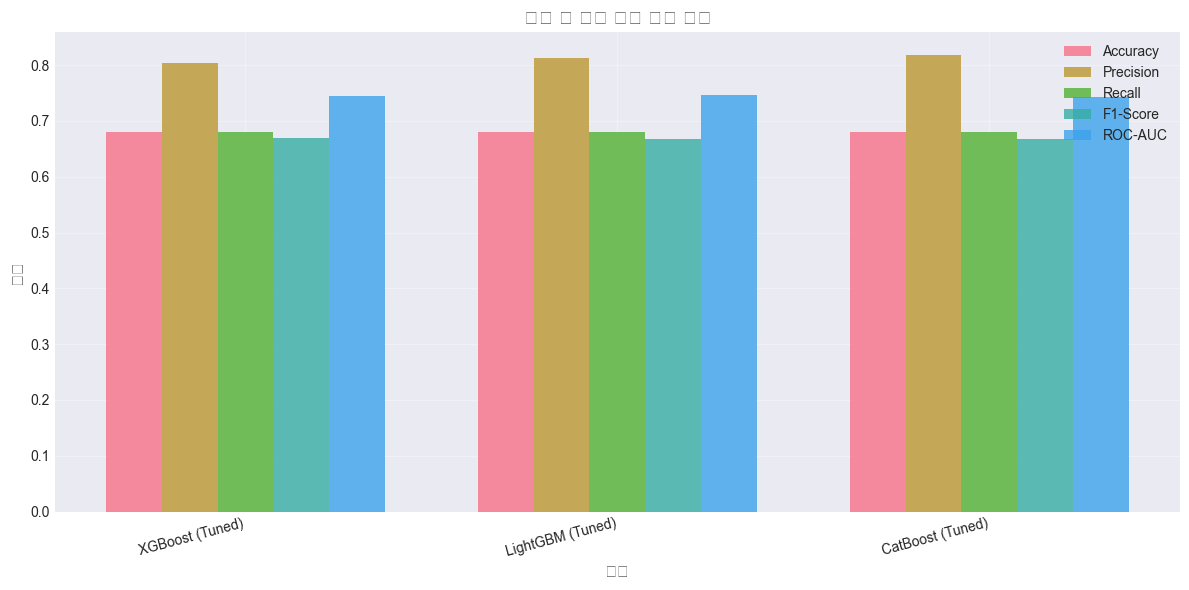

In [110]:
# 성능 시각화
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(final_df))
width = 0.15

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, final_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('모델', fontsize=12)
ax.set_ylabel('점수', fontsize=12)
ax.set_title('튜닝 후 최종 모델 성능 비교', fontsize=14, weight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(final_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 상세 모델 평가

In [111]:
# 최고 성능 모델 선택
best_model_name = final_df.iloc[0]['Model']
print(f"🏆 최고 성능 모델: {best_model_name}\n")

if 'XGBoost' in best_model_name:
    best_model = best_xgb
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
elif 'LightGBM' in best_model_name:
    best_model = best_lgbm
    y_pred_best = y_pred_lgbm
    y_pred_proba_best = y_pred_proba_lgbm
else:
    best_model = best_catboost
    y_pred_best = y_pred_catboost
    y_pred_proba_best = y_pred_proba_catboost

🏆 최고 성능 모델: XGBoost (Tuned)



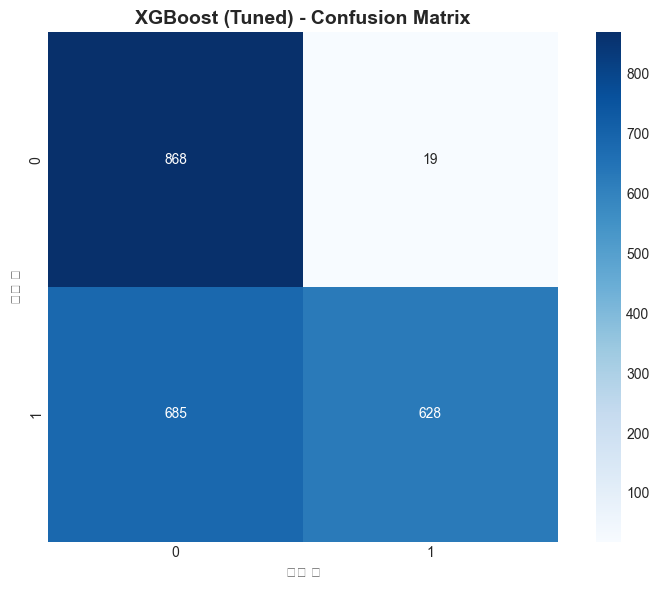


📋 분류 리포트:

              precision    recall  f1-score   support

           0       0.56      0.98      0.71       887
           1       0.97      0.48      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.76      0.73      0.68      2200
weighted avg       0.80      0.68      0.67      2200



In [112]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14, weight='bold')
plt.ylabel('실제 값')
plt.xlabel('예측 값')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 분류 리포트:\n")
print(classification_report(y_test, y_pred_best))

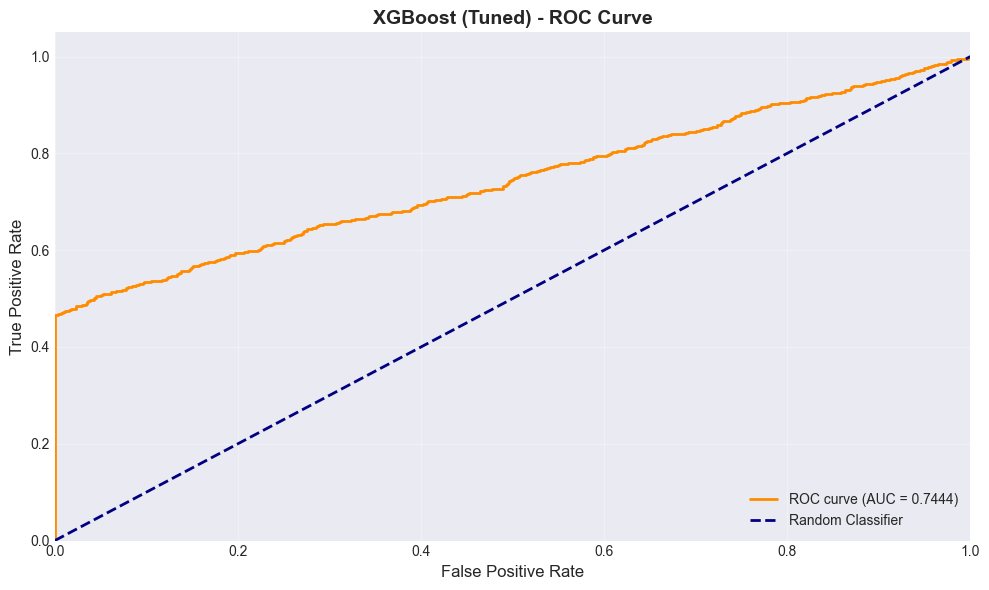

In [113]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'{best_model_name} - ROC Curve', fontsize=14, weight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

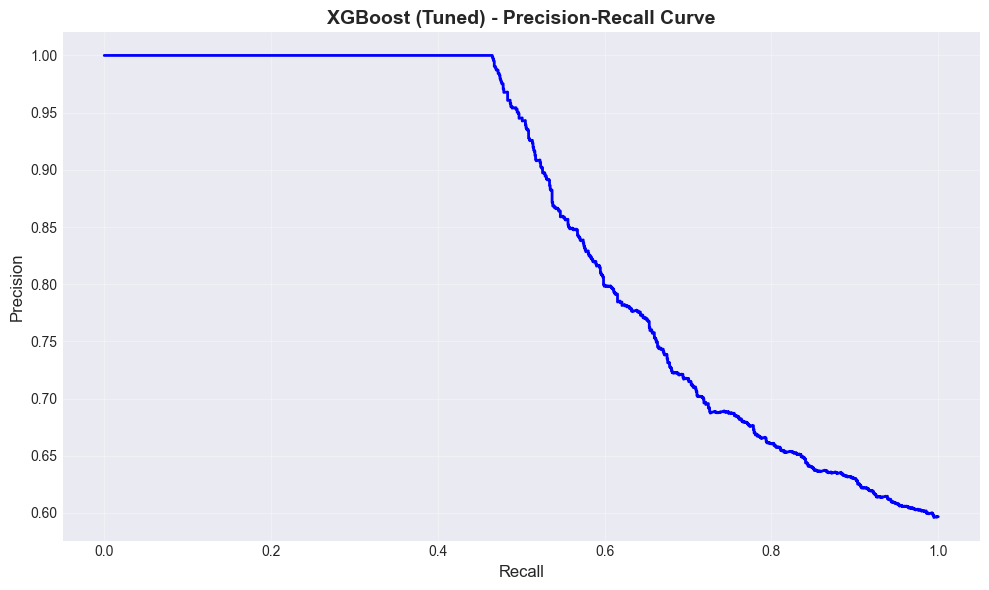

In [114]:
# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'{best_model_name} - Precision-Recall Curve', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. 특성 중요도 분석

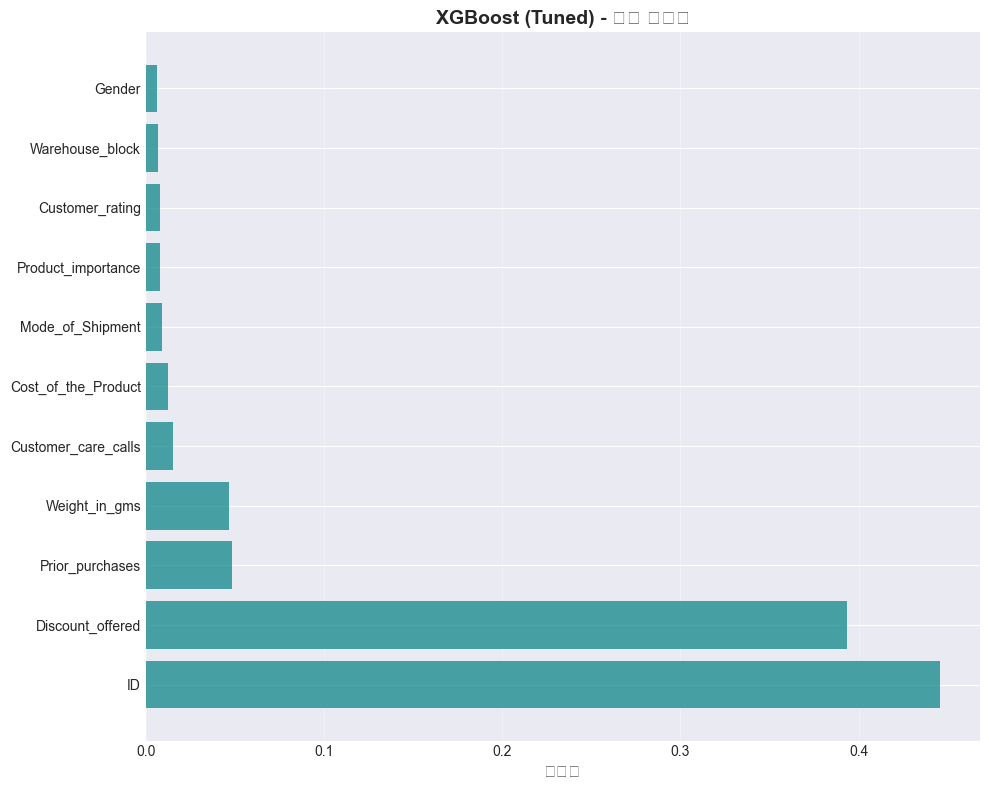


📊 Top 10 중요 특성:

            feature  importance
                 ID    0.445876
   Discount_offered    0.393640
    Prior_purchases    0.048417
      Weight_in_gms    0.046800
Customer_care_calls    0.015492
Cost_of_the_Product    0.012196
   Mode_of_Shipment    0.008947
 Product_importance    0.007798
    Customer_rating    0.007776
    Warehouse_block    0.007075


In [115]:
# 특성 중요도
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance)), feature_importance['importance'], 
             color='teal', alpha=0.7)
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('중요도', fontsize=12)
    plt.title(f'{best_model_name} - 특성 중요도', fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Top 10 중요 특성:\n")
    print(feature_importance.head(10).to_string(index=False))

## 11. SHAP 값 분석 (모델 해석)

🔍 SHAP 값 계산 중... (시간이 걸릴 수 있습니다)



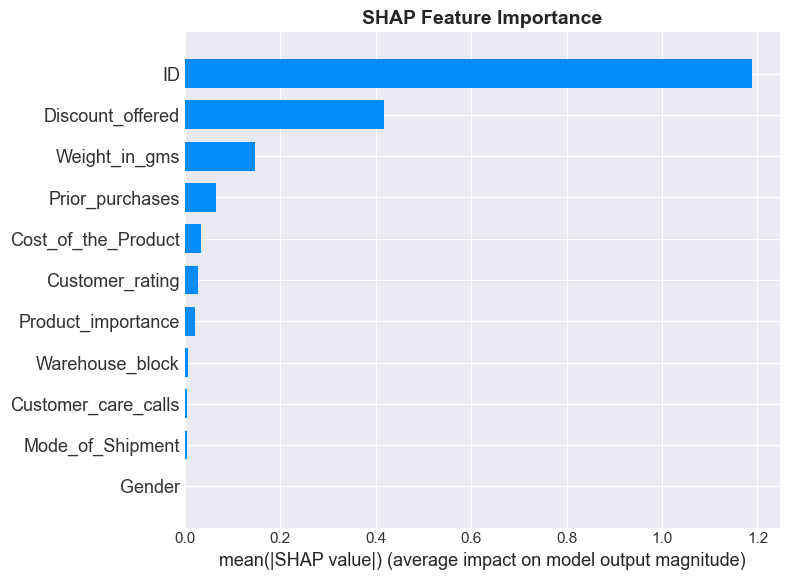

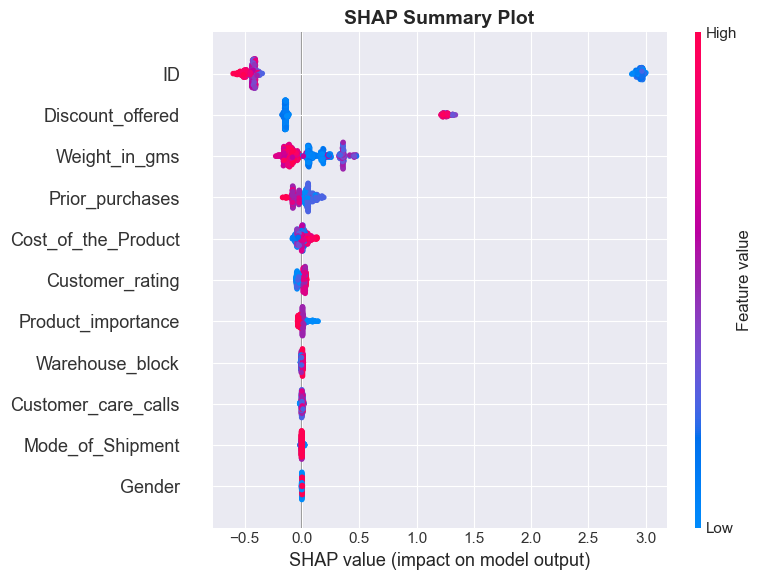

✅ SHAP 분석 완료!


In [116]:
# SHAP 분석 (샘플링으로 시간 절약)
if SHAP_AVAILABLE:
    print("🔍 SHAP 값 계산 중... (시간이 걸릴 수 있습니다)\n")
    
    # 샘플 데이터
    sample_size = min(500, len(X_test))
    X_test_sample = X_test.sample(sample_size, random_state=RANDOM_STATE)
    
    # SHAP Explainer
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Detailed Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('SHAP Summary Plot', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ SHAP 분석 완료!")
else:
    print("\n" + "="*60)
    print("⚠️ SHAP 분석 건너뜀")
    print("="*60)
    print("SHAP이 설치되지 않았거나 버전이 호환되지 않습니다.")
    print("특성 중요도는 섹션 10에서 확인할 수 있습니다.")
    print("\n해결 방법:")
    print("  1. 터미널에서 실행: pip uninstall shap scikit-learn -y")
    print("  2. 재설치: pip install scikit-learn==1.3.2 shap==0.44.0")
    print("  3. 주피터 커널 재시작")
    print("="*60)


## 12. 앙상블 모델 (선택 사항)

In [ ]:
# Voting Classifier (소프트 보팅)
from sklearn.ensemble import VotingClassifier

print("\n" + "="*60)
print("🎭 앙상블 모델 생성")
print("="*60)

ensemble = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('lgbm', best_lgbm),
        ('catboost', best_catboost)
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

# 앙상블 성능
ensemble_results = {
    'Model': 'Voting Ensemble',
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble, average='weighted'),
    'Recall': recall_score(y_test, y_pred_ensemble, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_ensemble, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_ensemble)
}

print("\n🎭 앙상블 모델 성능:")
for metric, value in ensemble_results.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

ValueError: The estimator XGBClassifier should be a classifier.

## 13. 최종 결과 요약

In [122]:
# 모든 결과 통합
all_results = pd.concat([
    results_df,  # 베이스라인
    final_df,    # 튜닝 모델
    # pd.DataFrame([ensemble_results])  # 12번 앙상블
], ignore_index=True)

all_results = all_results.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("🏆 전체 모델 성능 종합")
print("="*80)
print(all_results.to_string(index=False))

# Top 3 모델
print("\n" + "="*80)
print("🥇 Top 3 모델")
print("="*80)
print(all_results.head(3).to_string(index=False))


🏆 전체 모델 성능 종합
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.670000   0.700261 0.670000  0.672586 0.743542
  Gradient Boosting  0.678636   0.779052 0.678636  0.671504 0.746843
           LightGBM  0.667727   0.701419 0.667727  0.670016 0.740650
    XGBoost (Tuned)  0.680000   0.804638 0.680000  0.669305 0.744420
   LightGBM (Tuned)  0.680000   0.812403 0.680000  0.668170 0.747328
   CatBoost (Tuned)  0.680000   0.817845 0.680000  0.667386 0.742761
           CatBoost  0.667273   0.720074 0.667273  0.667154 0.739456
      Decision Tree  0.664091   0.664401 0.664091  0.664243 0.651463
Logistic Regression  0.653636   0.662307 0.653636  0.656234 0.733407
            XGBoost  0.652273   0.665018 0.652273  0.655353 0.730343

🥇 Top 3 모델
            Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
    Random Forest  0.670000   0.700261 0.670000  0.672586 0.743542
Gradient Boosting  0.678636   0.779052 0.678636  0.671504 0.746843
         Ligh

In [123]:
# 최종 시각화
fig = go.Figure()

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    fig.add_trace(go.Bar(
        name=metric,
        x=all_results['Model'],
        y=all_results[metric],
        text=all_results[metric].round(4),
        textposition='auto'
    ))

fig.update_layout(
    title='전체 모델 성능 비교 (인터랙티브)',
    xaxis_title='모델',
    yaxis_title='점수',
    barmode='group',
    height=600,
    template='plotly_white',
    xaxis={'tickangle': 45}
)

fig.show()

## 14. 모델 저장

In [124]:
import joblib

# 최고 성능 모델 저장
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("✅ 모델 저장 완료!")
print("  - best_model.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")

✅ 모델 저장 완료!
  - best_model.pkl
  - scaler.pkl
  - label_encoders.pkl


## 15. 결론 및 다음 단계

### 주요 성과
1. ✅ 상세한 EDA 및 시각화 완료
2. ✅ 7개 베이스라인 모델 비교
3. ✅ Optuna를 통한 하이퍼파라미터 튜닝
4. ✅ AutoGluon AutoML 적용
5. ✅ SHAP을 통한 모델 해석
6. ✅ 앙상블 모델 구축

### 추천 다음 단계
- 🔍 추가 특성 엔지니어링
- 📊 더 많은 하이퍼파라미터 튜닝 시도
- 🎯 클래스 불균형 처리 (SMOTE, Class Weights)
- 🧪 교차 검증 강화
- 📈 비즈니스 메트릭에 따른 임계값 조정
- 🚀 프로덕션 배포 준비